# Setup

In [144]:
import os
import json

from sklearn.linear_model import Lasso, Ridge, ElasticNet, HuberRegressor, BayesianRidge, QuantileRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.svm import SVR

from tqdm import tqdm 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

In [5]:
data_seed = 12

# PHASE 1: Load Data 

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
df = pd.read_csv(r"C:\Users\kerem.cantimur\Desktop\VscodeProjects\KaracaModelleri\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


,ChannelKey,DataAreaKey,InventKey,InventLocationKey,CampaignKrcKey,SalesQuantity,SalesGrossAmount,Return_Quantity,NetQuantity,NetGrossAmount,ReturnGrossAmount,ReturnNetAmount,NetAmountWOVat,DiscountAmount,DiscountGrossAmount,RboStoreKey,NetAmount,HourIntervalKey,IsFirstOrder
TransactionDateTime,,,,,,,,,,,,,,,,,,,
2024-02-08 22:12:00,2,3,others,others,6414,4.0,221.01,0.0,4.0,221.01,0.0,0.0,184.17,390.71,390.71,others,-184.17,23,True
2024-02-08 22:12:00,2,3,others,others,6414,1.0,127.51,0.0,1.0,127.51,0.0,0.0,106.26,343.07,343.07,others,-106.26,23,True
2024-02-08 22:12:00,2,3,others,others,6414,4.0,221.01,0.0,4.0,221.01,0.0,0.0,184.17,390.71,390.71,others,-184.17,23,True
2024-02-08 22:12:00,2,3,others,others,6414,1.0,127.52,0.0,1.0,127.52,0.0,0.0,106.27,343.06,343.06,others,-106.27,23,True
2024-02-08 22:12:00,2,3,others,others,6414,1.0,115.91,0.0,1.0,115.91,0.0,0.0,96.59,213.49,213.49,others,-96.59,23,True
2024-02-08 22:28:00,2,3,others,others,-99,1.0,110.49,0.0,1.0,110.49,0.0,0.0,92.07,42.44,42.44,others,-92.07,23,True
2024-02-08 22:28:00,2,3,others,others,6415,3.0,101.99,0.0,3.0,101.99,0.0,0.0,84.99,109.75,39.16,others,-84.99,23,True
2024-02-08 22:28:00,2,3,others,others,2,1.0,297.49,0.0,1.0,297.49,0.0,0.0,270.45,290.73,290.73,others,-270.45,23,True
2024-02-08 22:28:00,2,3,others,others,-99,1.0,84.99,0.0,1.0,84.99,0.0,0.0,70.83,32.65,32.65,others,-70.83,23,True


In [13]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [14]:
desired_column = 'NetAmountWOVat'

In [15]:
df = df[[desired_column]]

In [16]:
resampled_df = df.resample('60T', closed="left").sum()
resampled_df.shape

(206, 1)

In [17]:
resampled_df.head(10)

,NetAmountWOVat
TransactionDateTime,
2024-01-31 09:00:00,7444.94
2024-01-31 10:00:00,16321.85
2024-01-31 11:00:00,16112.86
2024-01-31 12:00:00,9955.61
2024-01-31 13:00:00,36883.48
2024-01-31 14:00:00,11374.87
2024-01-31 15:00:00,49252.87
2024-01-31 16:00:00,65630.39
2024-01-31 17:00:00,31425.66


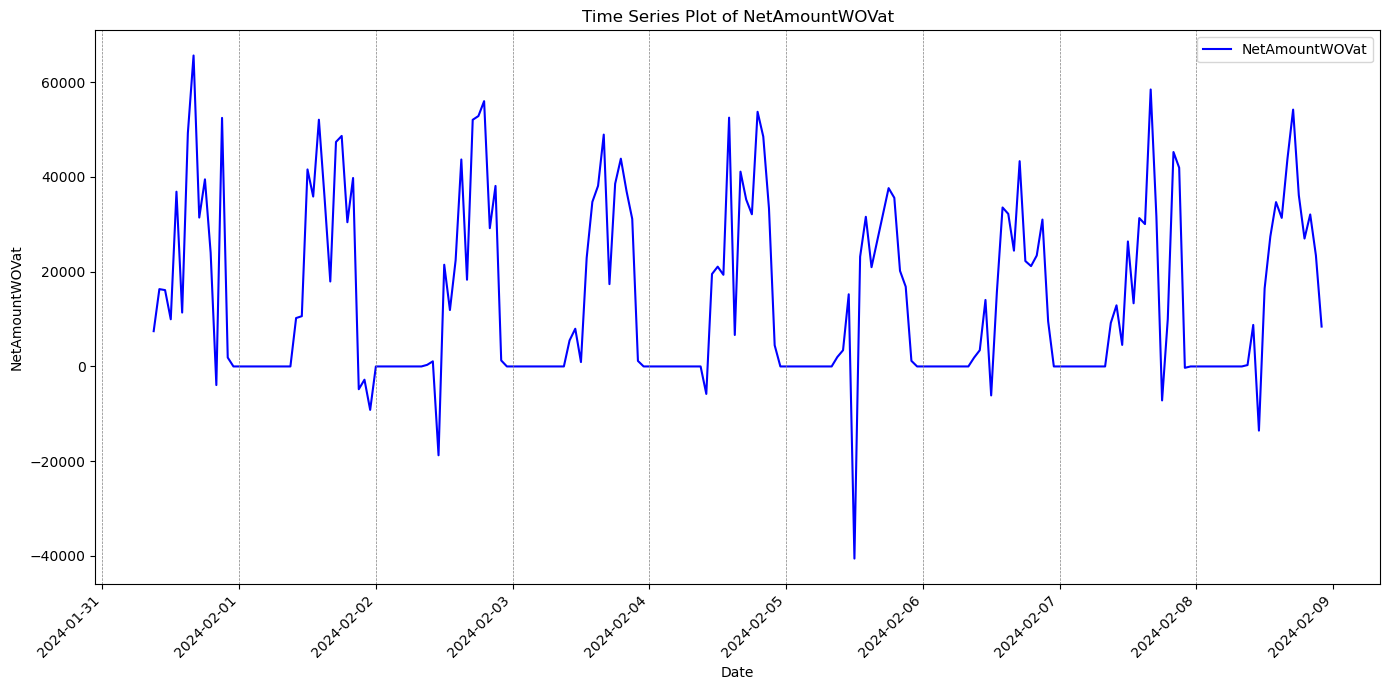

In [18]:
plt.figure(figsize=(14, 7))

# Plotting the NetAmountWOVat from resampled_df
plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label=f'{desired_column}', color='blue')

# Customize the plot
plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

# Date formatting for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjust this based on your data frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Adjust the date format as needed

# Rotate x-axis labels for skew
plt.xticks(rotation=45, ha='right')

# Add vertical dashed lines to separate days
for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()  # Ensure proper spacing
plt.show()

In [19]:
Q1 = resampled_df[desired_column].quantile(0.25)
Q3 = resampled_df[desired_column].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for outliers
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df[desired_column] < lower_bound) | (resampled_df[desired_column] > upper_bound)]

resampled_df = resampled_df[(resampled_df[desired_column] >= lower_bound) & (resampled_df[desired_column] <= upper_bound)]

# Display information about removed outliers
print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [20]:
resampled_df["HourInterval"] = resampled_df.index.hour
resampled_df['DayOfWeek'] = resampled_df.index.dayofweek + 1

resampled_df[f'{desired_column} Before'] = resampled_df[f'{desired_column}'].shift(1)

window_size = 3
resampled_df['RollingMean'] = resampled_df[f'{desired_column}'].rolling(window=window_size, min_periods=1).mean()
resampled_df['RollingStd'] = resampled_df[f'{desired_column}'].rolling(window=window_size, min_periods=1).std()

resampled_df = resampled_df.dropna()

In [21]:
print(resampled_df.shape)
resampled_df.head()

(203, 6)


,NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
TransactionDateTime,,,,,,
2024-01-31 10:00:00,16321.85,10,3,7444.94,11883.395000,6276.923257
2024-01-31 11:00:00,16112.86,11,3,16321.85,13293.216667,5065.834007
2024-01-31 12:00:00,9955.61,12,3,16112.86,14130.106667,3616.730018
2024-01-31 13:00:00,36883.48,13,3,9955.61,20983.983333,14109.338311
2024-01-31 14:00:00,11374.87,14,3,36883.48,19404.653333,15153.732575


In [22]:
sequence_length = 1
features = [f'{desired_column} Before', 'RollingMean', 'RollingStd', 'HourInterval', 'DayOfWeek']

## Train-Test Split

In [32]:
train_ratio = 0.8  # Adjust as needed
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [33]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 162 Valid Size: 41


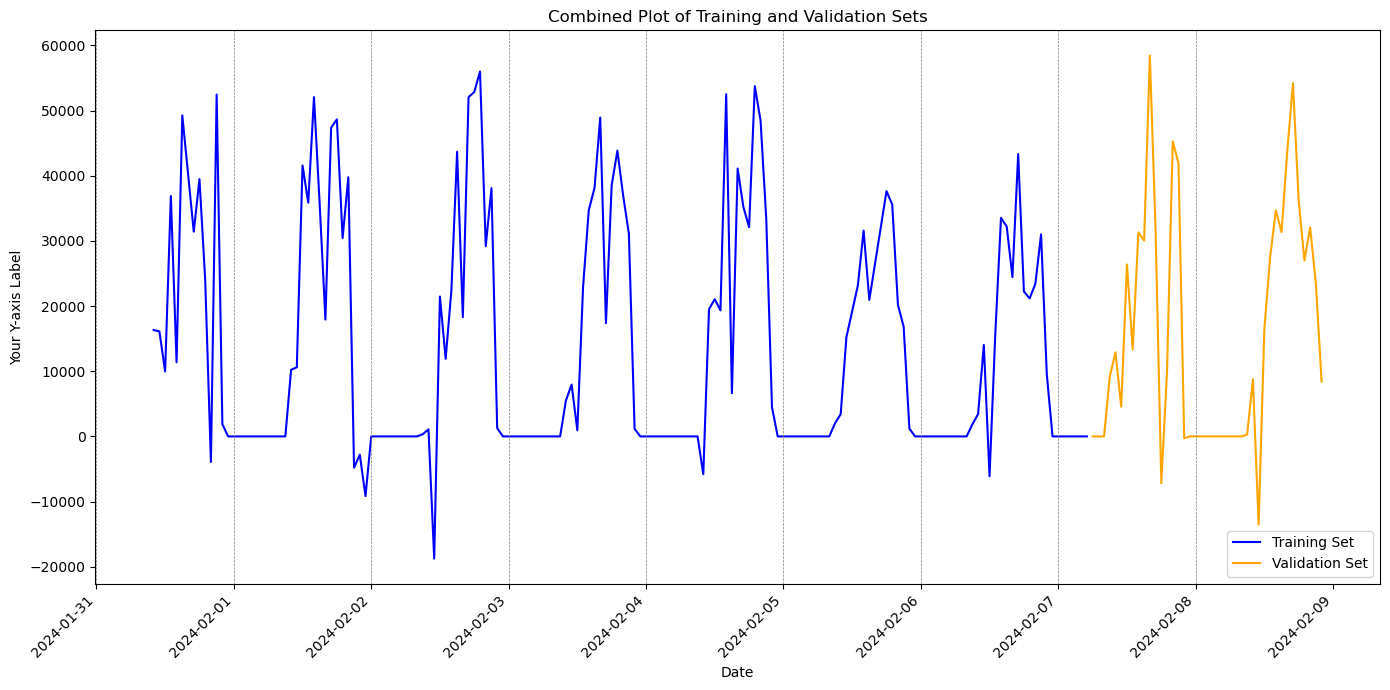

In [34]:
plt.figure(figsize=(14, 7))

# Plotting the training and validation sets
plt.plot(train_df.index, train_df[f'{desired_column}'], label='Training Set', color='blue')
plt.plot(valid_df.index, valid_df[f'{desired_column}'], label='Validation Set', color='orange')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

# Date formatting for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjust this based on your data frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Adjust the date format as needed

# Rotate x-axis labels for skew
plt.xticks(rotation=45, ha='right')

# Add vertical dashed lines to separate days
for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout() # Ensure proper spacing
plt.show()

## Normalization

In [35]:
train_original = train_df.copy()
valid_original = valid_df.copy()
train_original_stats = train_original.describe().to_dict()

train_original.describe()

,NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,13545.942778,11.567901,4.049383,13591.899198,13601.031821,7295.374151
std,17835.364789,7.031320,2.021015,17809.817537,15467.800980,7960.276102
min,-18747.920000,0.000000,1.000000,-18747.920000,-5778.856667,0.000000
25%,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,1226.130000,12.000000,4.000000,1561.635000,6222.766667,5107.380389
75%,28517.032500,18.000000,6.000000,28517.032500,26980.260833,13066.589081
max,55993.660000,23.000000,7.000000,55993.660000,53634.183333,31015.977716


In [36]:
import json

json_file_path = r"C:\Users\kerem.cantimur\Desktop\VscodeProjects\KaracaModelleri\norm_stats(RNN).json"

# Save the dictionary to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(train_original_stats, json_file)

In [37]:
for column in train_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue
        
    train_df[column] = (train_df[column] - train_original[column].mean()) / train_original[column].std()
    
for column in valid_df:
    if column in ['HourInterval', 'DayOfWeek']:
        continue

    valid_df[column] = (valid_df[column] - train_original[column].mean()) / train_original[column].std()

In [38]:
train_df.describe()

,NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
count,1.620000e+02,162.000000,162.000000,1.620000e+02,1.620000e+02,1.620000e+02
mean,-2.741291e-17,11.567901,4.049383,-2.467162e-17,-6.030841e-17,7.675616e-17
std,1.000000e+00,7.031320,2.021015,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.810665e+00,0.000000,1.000000,-1.815842e+00,-1.252918e+00,-9.164725e-01
25%,-7.594991e-01,5.000000,2.000000,-7.631689e-01,-8.793126e-01,-9.164725e-01
50%,-6.907519e-01,12.000000,4.000000,-6.754850e-01,-4.770080e-01,-2.748641e-01
75%,8.394047e-01,18.000000,6.000000,8.380284e-01,8.649729e-01,7.250019e-01
max,2.379975e+00,23.000000,7.000000,2.380808e+00,2.588160e+00,2.979872e+00


In [39]:
valid_df.describe()

,NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.112993,12.536585,3.560976,0.099052,0.105567,0.203946
std,1.029418,6.364344,0.502433,1.038108,0.991136,1.112481
min,-1.518725,0.000000,3.000000,-1.523484,-0.975974,-0.916473
25%,-0.759499,8.000000,3.000000,-0.763169,-0.879313,-0.916473
50%,-0.244404,13.000000,4.000000,-0.247335,-0.136271,-0.082208
75%,0.996013,18.000000,4.000000,0.994861,0.907949,0.823355
max,2.518003,23.000000,4.000000,2.519035,2.010542,3.228670


In [40]:
train_df.head(3)

,NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
TransactionDateTime,,,,,,
2024-01-31 10:00:00,0.155641,10,3,-0.345144,-0.111046,-0.127942
2024-01-31 11:00:00,0.143923,11,3,0.153283,-0.019900,-0.280083
2024-01-31 12:00:00,-0.201304,12,3,0.141549,0.034205,-0.462125


## Datasets

In [41]:
X_train, y_train = train_df.drop(columns=[desired_column]), train_df[desired_column]
X_valid, y_valid = valid_df.drop(columns=[desired_column]), valid_df[desired_column]

In [42]:
X_train

,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
TransactionDateTime,,,,,
2024-01-31 10:00:00,10,3,-0.345144,-0.111046,-0.127942
2024-01-31 11:00:00,11,3,0.153283,-0.019900,-0.280083
2024-01-31 12:00:00,12,3,0.141549,0.034205,-0.462125
2024-01-31 13:00:00,13,3,-0.204173,0.477311,0.855996
2024-01-31 14:00:00,14,3,1.307794,0.375207,0.987197
2024-01-31 15:00:00,15,3,-0.124484,1.222068,1.509961
2024-01-31 17:00:00,17,3,2.002321,1.104451,1.464082
2024-01-31 18:00:00,18,3,1.001344,1.710268,0.204994
2024-01-31 19:00:00,19,3,1.453968,1.166155,0.056296


In [43]:
y_train

TransactionDateTime
2024-01-31 10:00:00    0.155641
2024-01-31 11:00:00    0.143923
2024-01-31 12:00:00   -0.201304
2024-01-31 13:00:00    1.308498
2024-01-31 14:00:00   -0.121729
2024-01-31 15:00:00    2.002030
2024-01-31 17:00:00    1.002487
2024-01-31 18:00:00    1.454462
2024-01-31 19:00:00    0.586378
2024-01-31 20:00:00   -0.979875
2024-01-31 21:00:00    2.181818
2024-01-31 22:00:00   -0.654137
2024-01-31 23:00:00   -0.759499
2024-02-01 00:00:00   -0.759499
2024-02-01 01:00:00   -0.759499
2024-02-01 02:00:00   -0.759499
2024-02-01 03:00:00   -0.759499
2024-02-01 04:00:00   -0.759499
2024-02-01 05:00:00   -0.759499
2024-02-01 06:00:00   -0.759499
2024-02-01 07:00:00   -0.759499
2024-02-01 08:00:00   -0.759499
2024-02-01 09:00:00   -0.759499
2024-02-01 10:00:00   -0.186828
2024-02-01 11:00:00   -0.164682
2024-02-01 12:00:00    1.571691
2024-02-01 13:00:00    1.251139
2024-02-01 14:00:00    2.160352
2024-02-01 15:00:00    1.233339
2024-02-01 16:00:00    0.245823
2024-02-01 17:00:00 

# PHASE 3: Training

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(BiGRUModel, self).__init__()
        self.bi_gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bi_gru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BiLSTMModel, self).__init__()
        self.bi_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        out, _ = self.bi_lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.huber_loss = nn.SmoothL1Loss()

    def forward(self, predicted, target):
        mse_loss = self.mse_loss(predicted, target)
        huber_loss = self.huber_loss(predicted, target)
        custom_loss = (1 - self.alpha) * mse_loss + self.alpha * huber_loss

        return custom_loss

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def train_n_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, early_stopping=False, model_save_path=None):
    stats_dict = {'Epoch': [], 'Train Loss': [], 'Train RMSE': [], 'Valid Loss': [], 'Valid RMSE': []}

    if early_stopping:
        best_valid_loss = float('inf')
        consecutive_no_improvement = 0
        patience = 50
    
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        total_loss_train = 0.0
        total_samples_train = 0

        for inputs_train, targets_train in train_loader:
            optimizer.zero_grad()
            inputs_train = torch.tensor(inputs_train, dtype=torch.float32)
            targets_train = torch.tensor(targets_train, dtype=torch.float32).view(-1, 1)
            outputs_train = model(inputs_train)
            loss_train = criterion(outputs_train, targets_train)
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()
            total_samples_train += targets_train.size(0)

        # Validation
        model.eval()
        total_loss_valid = 0.0
        total_samples_valid = 0

        with torch.no_grad():
            for inputs_valid, targets_valid in valid_loader:
                inputs_valid = torch.tensor(inputs_valid, dtype=torch.float32)
                targets_valid = torch.tensor(targets_valid, dtype=torch.float32).view(-1, 1)
                outputs_valid = model(inputs_valid)
                loss_valid = criterion(outputs_valid, targets_valid)

                total_loss_valid += loss_valid.item()
                total_samples_valid += targets_valid.size(0)

        mean_loss_train = total_loss_train / len(train_loader)
        rmse_train = np.sqrt(mean_loss_train)

        mean_loss_valid = total_loss_valid / len(valid_loader)
        rmse_valid = np.sqrt(mean_loss_valid)

        step = max(1, num_epochs // 10)
        if epoch % step == 0:
            print("Epoch %d: Train Loss %.4f, Train RMSE %.4f | Valid Loss %.4f, Valid RMSE %.4f"
                    % (epoch, mean_loss_train, rmse_train, mean_loss_valid, rmse_valid))
            
        # Save the model if a save path is provided
        if model_save_path:
            epoch_model_save_path = f"{model_save_path}\model_epoch_{epoch}.pth"
            torch.save(model.state_dict(), epoch_model_save_path)
    
        # Save statistics to the dictionary
        stats_dict['Epoch'].append(epoch)
        stats_dict['Train Loss'].append(mean_loss_train)
        stats_dict['Train RMSE'].append(rmse_train)
        stats_dict['Valid Loss'].append(mean_loss_valid)
        stats_dict['Valid RMSE'].append(rmse_valid)

        

        if early_stopping:
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid
                consecutive_no_improvement = 0
            else:
                consecutive_no_improvement += 1
    
            if consecutive_no_improvement >= patience:
                print(f"Early stopping: No improvement for {patience} consecutive epochs.")
                break

    # Convert the dictionary to a DataFrame
    stats_df = pd.DataFrame(stats_dict)
    
    return stats_df

## Main training phase

### Lasso

In [129]:
# Define the parameter grid for Lasso Regression
lasso_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Create Lasso Regression model
lasso_model = Lasso()

# Perform Grid Search
lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train, y_train)

# Get the best parameters
best_lasso_params = lasso_grid_search.best_params_

# Print the best parameters
print(f'Best Lasso Parameters: {best_lasso_params}')

lasso_model = Lasso(**best_lasso_params)  
lasso_model.fit(X_train, y_train)

# Make predictions
lasso_pred = lasso_model.predict(X_valid)

# Evaluate model performance
mse = mean_squared_error(y_valid, lasso_pred)
print(f'Mean Squared Error: {mse}')

Best Lasso Parameters: {'alpha': 0.01}
Mean Squared Error: 0.336245855126556


### Ridge

In [130]:
# Define the parameter grid for Ridge Regression
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Create Ridge Regression model
ridge_model = Ridge()

# Perform Grid Search
ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

# Get the best parameters
best_ridge_params = ridge_grid_search.best_params_

# Print the best parameters
print(f'Best Ridge Parameters: {best_ridge_params}')

ridge_model = Ridge(**best_ridge_params)  
ridge_model.fit(X_train, y_train)

# Make predictions
ridge_pred = ridge_model.predict(X_valid)

# Evaluate model performance
mse = mean_squared_error(y_valid, ridge_pred)
print(f'Mean Squared Error: {mse}')

Best Ridge Parameters: {'alpha': 0.1}
Mean Squared Error: 0.3347455151338198


### Elastic Net

In [131]:
elasticnet_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9]}

# Create Elastic Net Regression model
elasticnet_model = ElasticNet()

# Perform Grid Search
elasticnet_grid_search = GridSearchCV(elasticnet_model, elasticnet_param_grid, cv=5, scoring='neg_mean_squared_error')
elasticnet_grid_search.fit(X_train, y_train)

# Get the best parameters
best_elasticnet_params = elasticnet_grid_search.best_params_

# Print the best parameters
print(f'Best Elastic Net Parameters: {best_elasticnet_params}')

elastic_model = ElasticNet(**best_elasticnet_params)  
elastic_model.fit(X_train, y_train)

# Make predictions
elastic_pred = elastic_model.predict(X_valid)

# Evaluate model performance
mse = mean_squared_error(y_valid, elastic_pred)
print(f'Mean Squared Error: {mse}')

Best Elastic Net Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Mean Squared Error: 0.33637903659017226


## Huber Regression

In [134]:
huber_param_grid = {'epsilon': [1.35, 1.5, 1.75]}
huber_grid_search = GridSearchCV(HuberRegressor(), huber_param_grid, cv=5, scoring='neg_mean_squared_error')
huber_grid_search.fit(X_train, y_train)
huber_best_model = huber_grid_search.best_estimator_

huber_best_predictions = huber_best_model.predict(X_valid)
mse = mean_squared_error(y_valid, huber_best_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.3362970637973881


## Quantile Regression

In [137]:
quantile_param_grid = {'alpha': [0.1, 0.5, 0.9]}
quantile_grid_search = GridSearchCV(QuantileRegressor(), quantile_param_grid, cv=5, scoring='neg_mean_squared_error')
quantile_grid_search.fit(X_train, y_train)
quantile_best_model = quantile_grid_search.best_estimator_

quantile_best_predictions = quantile_best_model.predict(X_valid)
mse = mean_squared_error(y_valid, quantile_best_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.41212677155381555


## Bayesian Ridge

In [142]:
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

bayesian_predictions = bayesian_model.predict(X_valid)
mse = mean_squared_error(y_valid, bayesian_predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.33520636606015813


## SVR

In [195]:
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.5, 1.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Add other kernels you want to explore
}

svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train, y_train)
svr_best_model = svr_grid_search.best_estimator_

svr_best_predictions = svr_best_model.predict(X_valid)
mse = mean_squared_error(y_valid, svr_best_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Best SVR Parameters: {svr_grid_search.best_params_}')

Mean Squared Error: 0.3017706892562637
Best SVR Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


## Poly Regression

In [147]:
# Create a pipeline with PolynomialFeatures and LinearRegression
polyreg = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define the parameter grid for PolynomialFeatures' degree
param_grid = {'polynomialfeatures__degree': [2, 3, 4]}  # You can extend the list as needed

# Create the GridSearchCV object
grid_search = GridSearchCV(polyreg, param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best model
best_polyreg = grid_search.best_estimator_

# Make predictions with the best model
polyreg_predictions = best_polyreg.predict(X_valid)

# Evaluate the best model
polyreg_mse = mean_squared_error(y_valid, polyreg_predictions)

# Print the best degree and MSE for Polynomial Regression
print(f"Best Polynomial Degree: {grid_search.best_params_['polynomialfeatures__degree']}")
print(f"Best Polynomial Regression MSE: {polyreg_mse}")

Best Polynomial Degree: 2
Best Polynomial Regression MSE: 0.363310169172855


# PHASE 4: Testing

## Plot inference

In [64]:
desired_column = "NetAmountWOVat"

In [149]:
mean = train_original_stats[desired_column]["mean"]
std = train_original_stats[desired_column]["std"]

# Actual
actual_train_values = train_df[desired_column]
actual_valid_values = valid_df[desired_column]

actual_train_values_denorm = train_df[desired_column] * std + mean
actual_valid_values_denorm = valid_df[desired_column] * std + mean

# Lasso
predicted_train_values_lasso = lasso_model.predict(X_train)
predicted_valid_values_lasso = lasso_model.predict(X_valid)

predicted_train_values_lasso_denorm = predicted_train_values_lasso * std + mean
predicted_valid_values_lasso_denorm = predicted_valid_values_lasso * std + mean

# Ridge
predicted_train_values_ridge = ridge_model.predict(X_train)
predicted_valid_values_ridge = ridge_model.predict(X_valid)

predicted_train_values_ridge_denorm = predicted_train_values_ridge * std + mean
predicted_valid_values_ridge_denorm = predicted_valid_values_ridge * std + mean

# Elastic Net
predicted_train_values_elastic = elastic_model.predict(X_train)
predicted_valid_values_elastic = elastic_model.predict(X_valid)

predicted_train_values_elastic_denorm = predicted_train_values_elastic * std + mean
predicted_valid_values_elastic_denorm = predicted_valid_values_elastic * std + mean

# Huber
predicted_train_values_huber = huber_best_model.predict(X_train)
predicted_valid_values_huber = huber_best_model.predict(X_valid)

predicted_train_values_huber_denorm = predicted_train_values_huber * std + mean
predicted_valid_values_huber_denorm = predicted_valid_values_huber * std + mean

# Quantile
predicted_train_values_quantile = quantile_best_model.predict(X_train)
predicted_valid_values_quantile = quantile_best_model.predict(X_valid)

predicted_train_values_quantile_denorm = predicted_train_values_quantile * std + mean
predicted_valid_values_quantile_denorm = predicted_valid_values_quantile * std + mean

# Bayesian
predicted_train_values_bayesian = bayesian_model.predict(X_train)
predicted_valid_values_bayesian = bayesian_model.predict(X_valid)

predicted_train_values_bayesian_denorm = predicted_train_values_bayesian * std + mean
predicted_valid_values_bayesian_denorm = predicted_valid_values_bayesian * std + mean

# SVR
predicted_train_values_svr = svr_best_model.predict(X_train)
predicted_valid_values_svr = svr_best_model.predict(X_valid)

predicted_train_values_svr_denorm = predicted_train_values_svr * std + mean
predicted_valid_values_svr_denorm = predicted_valid_values_svr * std + mean

# Poly
predicted_train_values_poly = best_polyreg.predict(X_train)
predicted_valid_values_poly = best_polyreg.predict(X_valid)

predicted_train_values_poly_denorm = predicted_train_values_poly * std + mean
predicted_valid_values_poly_denorm = predicted_valid_values_poly * std + mean

# Ensemble 
ensemble_train_predictions = (predicted_train_values_lasso + predicted_train_values_ridge + predicted_train_values_elastic +
                              predicted_train_values_huber + predicted_train_values_quantile + predicted_train_values_bayesian +
                              predicted_train_values_svr + predicted_train_values_poly) / 8
ensemble_valid_predictions = (predicted_valid_values_lasso + predicted_valid_values_ridge + predicted_valid_values_elastic +
                              predicted_valid_values_huber + predicted_valid_values_quantile + predicted_valid_values_bayesian +
                              predicted_valid_values_svr + predicted_valid_values_poly) / 8

ensemble_train_predictions_denorm = (predicted_train_values_lasso_denorm + predicted_train_values_ridge_denorm + predicted_train_values_elastic_denorm) / 3
ensemble_valid_predictions_denorm = (predicted_valid_values_lasso_denorm + predicted_valid_values_ridge_denorm + predicted_valid_values_elastic_denorm) / 3

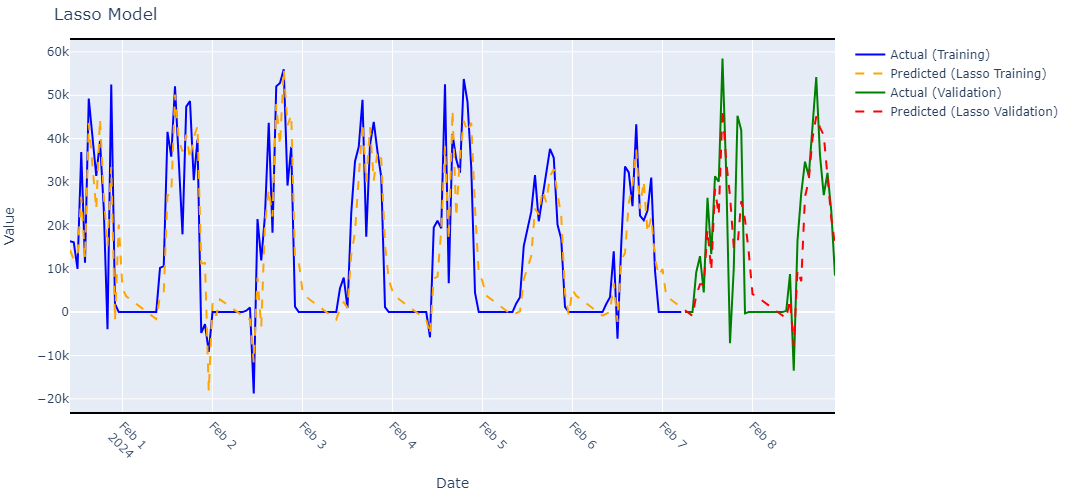

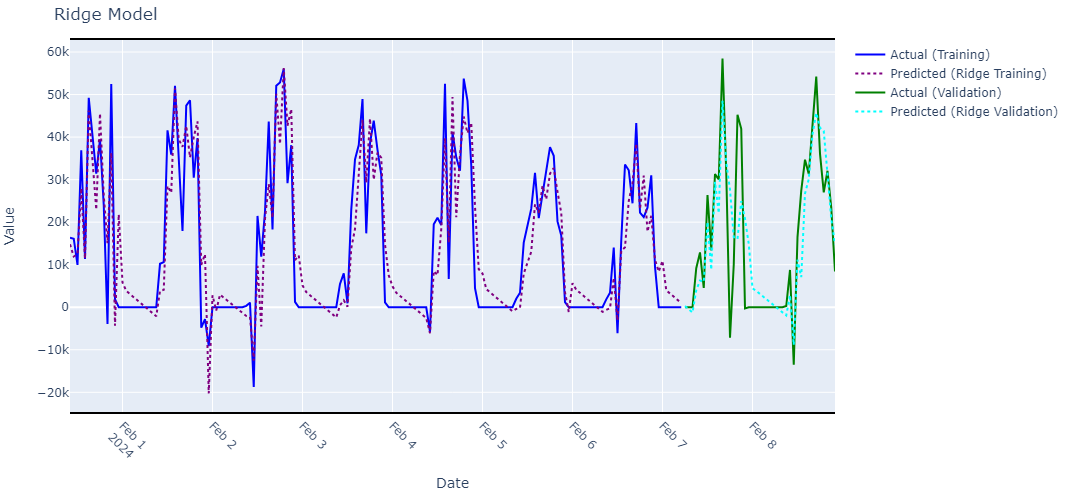

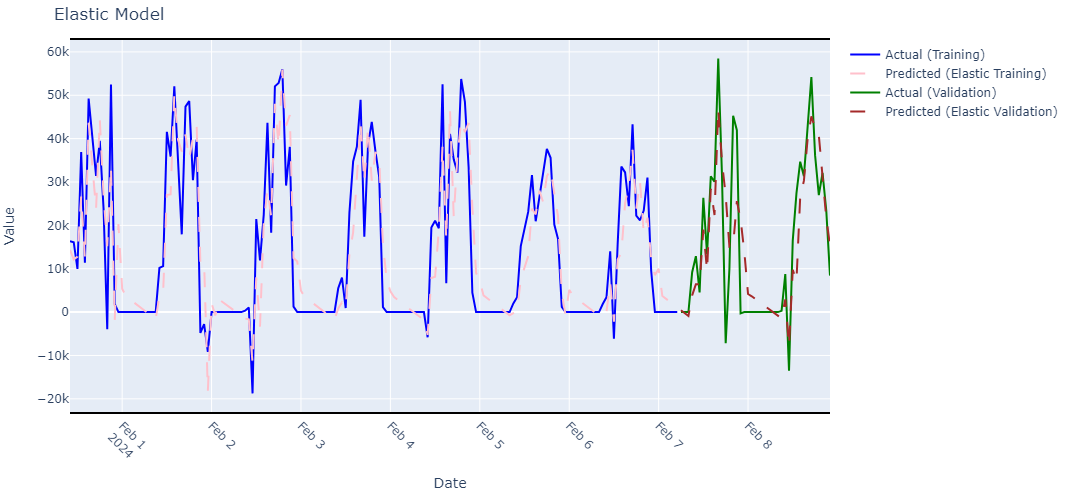

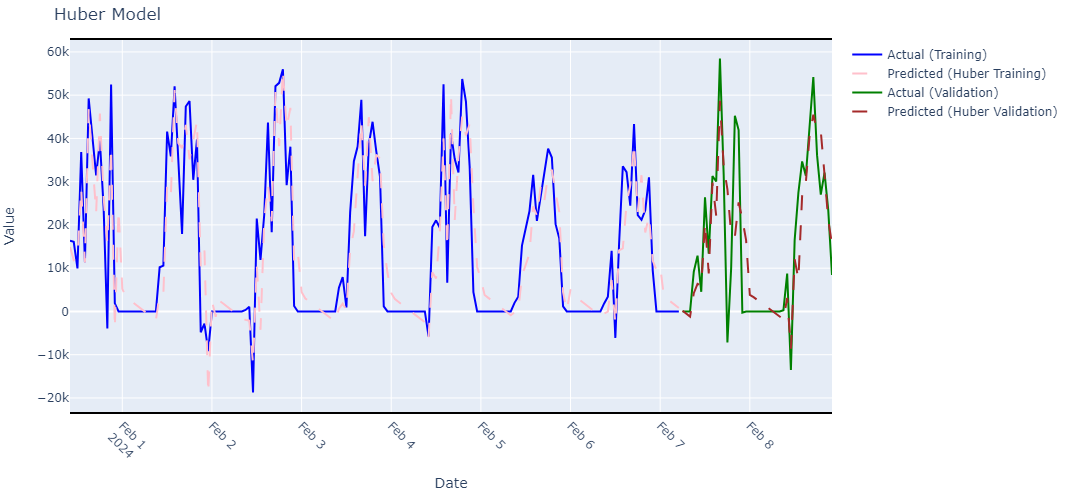

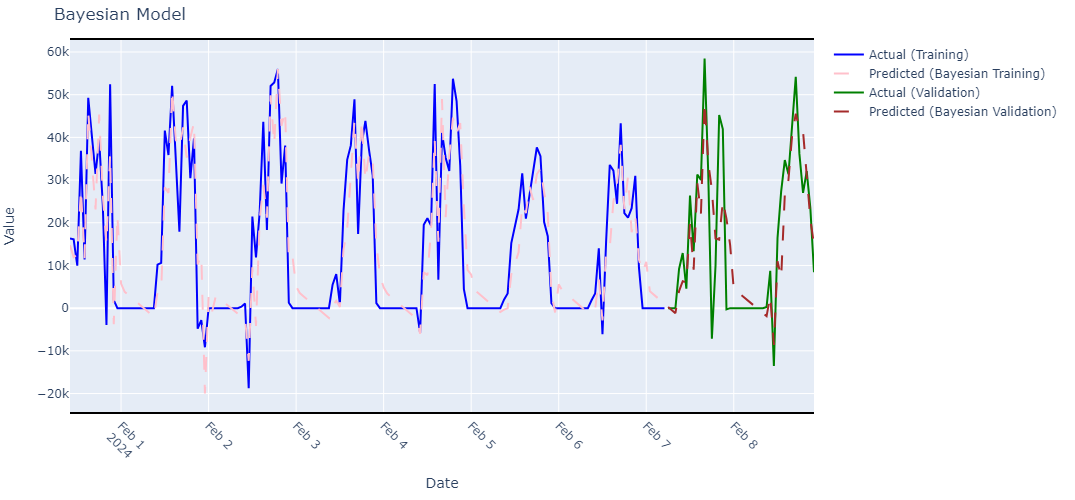

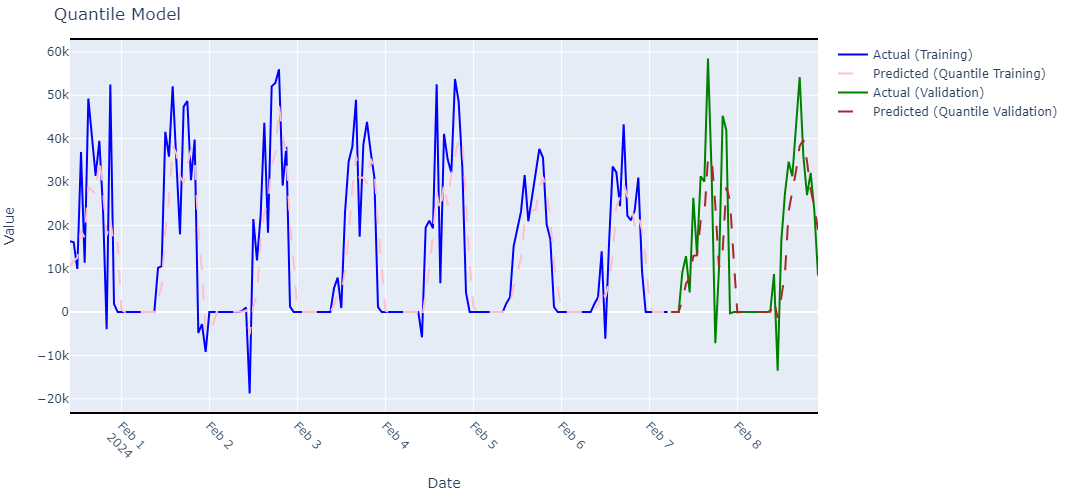

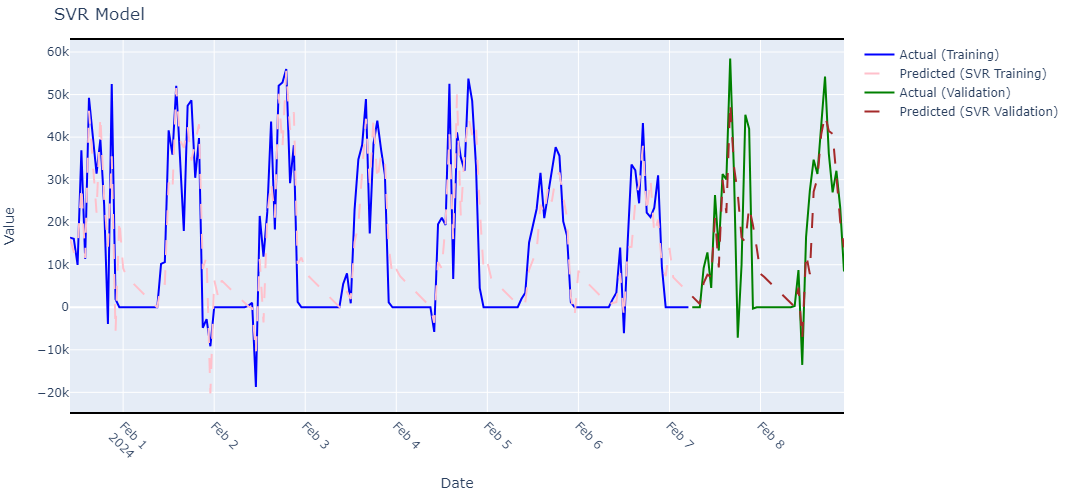

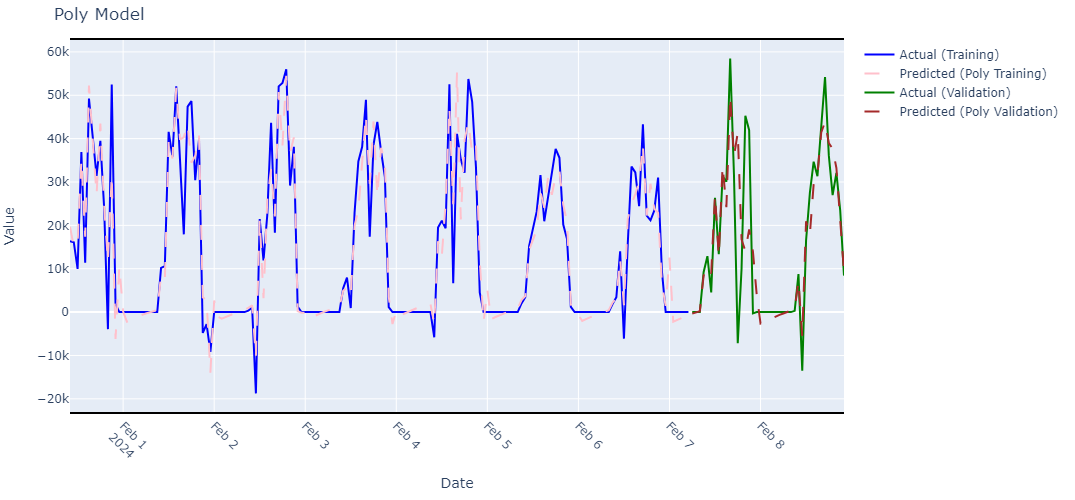

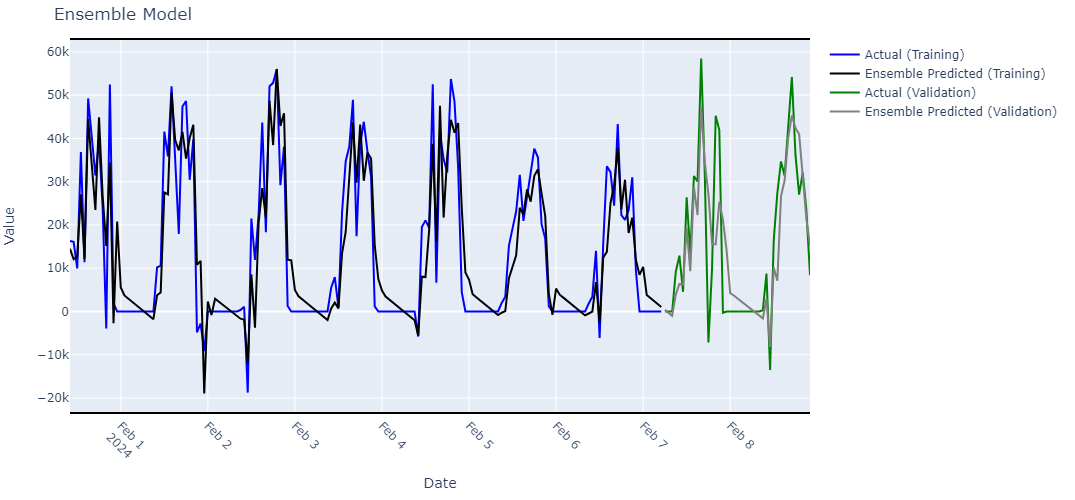

In [151]:
dates = resampled_df.index

trace_actual_train = go.Scatter(x=dates[:len(actual_train_values_denorm)], y=actual_train_values_denorm, mode='lines', name='Actual (Training)', line=dict(color='blue'))
trace_actual_valid = go.Scatter(x=dates[-len(actual_valid_values_denorm):], y=actual_valid_values_denorm, mode='lines', name='Actual (Validation)', line=dict(color='green'))

# Create traces for Lasso
trace_predicted_train_lasso = go.Scatter(x=dates[:len(predicted_train_values_lasso_denorm)], y=predicted_train_values_lasso_denorm, mode='lines', name='Predicted (Lasso Training)', line=dict(color='orange', dash='dash'))
trace_predicted_valid_lasso = go.Scatter(x=dates[-len(predicted_valid_values_lasso_denorm):], y=predicted_valid_values_lasso_denorm, mode='lines', name='Predicted (Lasso Validation)', line=dict(color='red', dash='dash'))

# Create traces for Ridge
trace_predicted_train_ridge = go.Scatter(x=dates[:len(predicted_train_values_ridge_denorm)], y=predicted_train_values_ridge_denorm, mode='lines', name='Predicted (Ridge Training)', line=dict(color='purple', dash='dot'))
trace_predicted_valid_ridge = go.Scatter(x=dates[-len(predicted_valid_values_ridge_denorm):], y=predicted_valid_values_ridge_denorm, mode='lines', name='Predicted (Ridge Validation)', line=dict(color='cyan', dash='dot'))

# Create traces for Elastic Net
trace_predicted_train_elastic = go.Scatter(x=dates[:len(predicted_train_values_elastic_denorm)], y=predicted_train_values_elastic_denorm, mode='lines', name='Predicted (Elastic Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_elastic = go.Scatter(x=dates[-len(predicted_valid_values_elastic_denorm):], y=predicted_valid_values_elastic_denorm, mode='lines', name='Predicted (Elastic Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for Huber
trace_predicted_train_huber = go.Scatter(x=dates[:len(predicted_train_values_huber_denorm)], y=predicted_train_values_huber_denorm, mode='lines', name='Predicted (Huber Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_huber = go.Scatter(x=dates[-len(predicted_valid_values_huber_denorm):], y=predicted_valid_values_huber_denorm, mode='lines', name='Predicted (Huber Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for Quantile
trace_predicted_train_quantile = go.Scatter(x=dates[:len(predicted_train_values_quantile_denorm)], y=predicted_train_values_quantile_denorm, mode='lines', name='Predicted (Quantile Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_quantile = go.Scatter(x=dates[-len(predicted_valid_values_quantile_denorm):], y=predicted_valid_values_quantile_denorm, mode='lines', name='Predicted (Quantile Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for Bayesian
trace_predicted_train_bayesian = go.Scatter(x=dates[:len(predicted_train_values_bayesian_denorm)], y=predicted_train_values_bayesian_denorm, mode='lines', name='Predicted (Bayesian Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_bayesian = go.Scatter(x=dates[-len(predicted_valid_values_bayesian_denorm):], y=predicted_valid_values_bayesian_denorm, mode='lines', name='Predicted (Bayesian Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for SVR
trace_predicted_train_svr = go.Scatter(x=dates[:len(predicted_train_values_svr_denorm)], y=predicted_train_values_svr_denorm, mode='lines', name='Predicted (SVR Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_svr = go.Scatter(x=dates[-len(predicted_valid_values_svr_denorm):], y=predicted_valid_values_svr_denorm, mode='lines', name='Predicted (SVR Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for Poly
trace_predicted_train_poly = go.Scatter(x=dates[:len(predicted_train_values_poly_denorm)], y=predicted_train_values_poly_denorm, mode='lines', name='Predicted (Poly Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_poly = go.Scatter(x=dates[-len(predicted_valid_values_poly_denorm):], y=predicted_valid_values_poly_denorm, mode='lines', name='Predicted (Poly Validation)', line=dict(color='brown', dash='longdash'))

# Create traces for Ensemble
trace_train_ensemble = go.Scatter(x=dates[:len(ensemble_train_predictions_denorm)], y=ensemble_train_predictions_denorm, mode='lines', name='Ensemble Predicted (Training)', line=dict(color='black', dash='solid'))
trace_valid_ensemble = go.Scatter(x=dates[-len(ensemble_valid_predictions_denorm):], y=ensemble_valid_predictions_denorm, mode='lines', name='Ensemble Predicted (Validation)', line=dict(color='gray', dash='solid'))

# Create layouts
layout_lasso = go.Layout(
    title='Lasso Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ridge = go.Layout(
    title='Ridge Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_elastic = go.Layout(
    title='Elastic Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_huber = go.Layout(
    title='Huber Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_quantile = go.Layout(
    title='Quantile Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_bayesian = go.Layout(
    title='Bayesian Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_svr = go.Layout(
    title='SVR Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_poly = go.Layout(
    title='Poly Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ensemble = go.Layout(
    title='Ensemble Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

# Create figures
fig_lasso = go.Figure(data=[trace_actual_train, trace_predicted_train_lasso, trace_actual_valid, trace_predicted_valid_lasso], layout=layout_lasso)
fig_ridge = go.Figure(data=[trace_actual_train, trace_predicted_train_ridge, trace_actual_valid, trace_predicted_valid_ridge], layout=layout_ridge)
fig_elastic = go.Figure(data=[trace_actual_train, trace_predicted_train_elastic, trace_actual_valid, trace_predicted_valid_elastic], layout=layout_elastic)
fig_huber = go.Figure(data=[trace_actual_train, trace_predicted_train_huber, trace_actual_valid, trace_predicted_valid_huber], layout=layout_huber)
fig_bayesian = go.Figure(data=[trace_actual_train, trace_predicted_train_bayesian, trace_actual_valid, trace_predicted_valid_bayesian], layout=layout_bayesian)
fig_quantile = go.Figure(data=[trace_actual_train, trace_predicted_train_quantile, trace_actual_valid, trace_predicted_valid_quantile], layout=layout_quantile)
fig_svr = go.Figure(data=[trace_actual_train, trace_predicted_train_svr, trace_actual_valid, trace_predicted_valid_svr], layout=layout_svr)
fig_poly = go.Figure(data=[trace_actual_train, trace_predicted_train_poly, trace_actual_valid, trace_predicted_valid_poly], layout=layout_poly)
fig_ensemble = go.Figure(data=[trace_actual_train, trace_train_ensemble, trace_actual_valid, trace_valid_ensemble], layout=layout_ensemble)

# Show interactive plots
fig_lasso.show()
fig_ridge.show()
fig_elastic.show()
fig_huber.show()
fig_bayesian.show()
fig_quantile.show()
fig_svr.show()
fig_poly.show()
fig_ensemble.show()

In [153]:
predictions_train_df = pd.DataFrame({
    'Date': train_df.index,
    f'Actual {desired_column}': actual_train_values_denorm,
    f'Lasso Predicted {desired_column}': predicted_train_values_lasso_denorm,
    f'Ridge Predicted {desired_column}': predicted_train_values_ridge_denorm,
    f'Elastic Predicted {desired_column}': predicted_train_values_elastic_denorm,
    f'Huber Predicted {desired_column}': predicted_train_values_huber_denorm,
    f'Quantile Predicted {desired_column}': predicted_train_values_quantile_denorm,
    f'Bayesian Predicted {desired_column}': predicted_train_values_bayesian_denorm,
    f'SVR Predicted {desired_column}': predicted_train_values_svr_denorm,
    f'Poly Predicted {desired_column}': predicted_train_values_poly_denorm,
    f'Ensemble Predicted {desired_column}': ensemble_train_predictions_denorm
})

predictions_valid_df = pd.DataFrame({
    'Date': valid_df.index,
    f'Actual {desired_column}': actual_valid_values_denorm,
    f'Lasso Predicted {desired_column}': predicted_valid_values_lasso_denorm,
    f'Ridge Predicted {desired_column}': predicted_valid_values_ridge_denorm,
    f'Elastic Predicted {desired_column}': predicted_valid_values_elastic_denorm,
    f'Huber Predicted {desired_column}': predicted_valid_values_huber_denorm,
    f'Quantile Predicted {desired_column}': predicted_valid_values_quantile_denorm,
    f'Bayesian Predicted {desired_column}': predicted_valid_values_bayesian_denorm,
    f'SVR Predicted {desired_column}': predicted_valid_values_svr_denorm,
    f'Poly Predicted {desired_column}': predicted_valid_values_poly_denorm,
    f'Ensemble Predicted {desired_column}': ensemble_valid_predictions_denorm
})


# Concatenating the DataFrames into a single DataFrame
predictions_all_df = pd.concat([predictions_train_df, predictions_valid_df], ignore_index=True)
predictions_all_df.set_index('Date', inplace=True)

result_df = predictions_all_df.copy()
result_df.tail(10)

,Actual NetAmountWOVat,Lasso Predicted NetAmountWOVat,Ridge Predicted NetAmountWOVat,Elastic Predicted NetAmountWOVat,Huber Predicted NetAmountWOVat,Quantile Predicted NetAmountWOVat,Bayesian Predicted NetAmountWOVat,SVR Predicted NetAmountWOVat,Poly Predicted NetAmountWOVat,Ensemble Predicted NetAmountWOVat
Date,,,,,,,,,,
2024-02-08 13:00:00,27416.69,7114.707880,7078.839872,7181.606836,7454.339206,8987.944304,7210.892955,7786.063182,17872.214875,7125.051529
2024-02-08 14:00:00,34684.19,26578.832967,26719.778700,26569.492133,26681.566011,23267.791037,26676.228687,27156.465276,29483.229722,26622.701267
2024-02-08 15:00:00,31353.18,30363.056502,30094.435250,30313.968741,29859.253184,27672.414343,30054.785062,30334.709244,31679.519359,30257.153498
2024-02-08 16:00:00,43761.77,40047.634741,40685.168884,40014.935544,40645.818528,32512.309220,40503.515598,40681.248133,41446.604374,40249.246390
2024-02-08 17:00:00,54206.70,45150.533410,45665.455738,45130.191394,45491.250768,38293.063805,45531.050796,45176.335483,43850.651442,45315.393514
2024-02-08 18:00:00,36130.63,42529.612792,42174.808618,42482.539686,41789.718962,39707.700857,42156.393498,41438.826427,38968.040412,42395.653698
2024-02-08 19:00:00,26992.63,40807.698286,41437.722338,40800.549360,41644.904049,34742.238786,41305.268455,40747.398448,37676.050886,41015.323328
2024-02-08 20:00:00,32083.99,31277.823135,31281.260471,31224.840244,31628.249356,28191.546418,31181.323479,30834.797584,33220.782204,31261.307950
2024-02-08 21:00:00,23429.17,21734.736992,20770.651143,21670.800329,21078.205550,24430.553435,20834.416605,20180.904749,21785.983162,21392.062821


## Save History

In [154]:
result_df.to_csv("history.csv", index=False)

## Table Inference

In [155]:
# Replace df_predictions with result_df
result_df["Original_Status"] = np.where(result_df[f"Actual {desired_column}"].shift(-1) > result_df[f"Actual {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Lasso"] = np.where(result_df[f"Lasso Predicted {desired_column}"].shift(-1) > result_df[f"Lasso Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Ridge"] = np.where(result_df[f"Ridge Predicted {desired_column}"].shift(-1) > result_df[f"Ridge Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Elastic"] = np.where(result_df[f"Elastic Predicted {desired_column}"].shift(-1) > result_df[f"Elastic Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Huber"] = np.where(result_df[f"Huber Predicted {desired_column}"].shift(-1) > result_df[f"Huber Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Quantile"] = np.where(result_df[f"Quantile Predicted {desired_column}"].shift(-1) > result_df[f"Quantile Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Bayesian"] = np.where(result_df[f"Bayesian Predicted {desired_column}"].shift(-1) > result_df[f"Bayesian Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_SVR"] = np.where(result_df[f"SVR Predicted {desired_column}"].shift(-1) > result_df[f"SVR Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_Poly"] = np.where(result_df[f"Poly Predicted {desired_column}"].shift(-1) > result_df[f"Poly Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Ensemble_Status"] = np.where(result_df[f"Ensemble Predicted {desired_column}"].shift(-1) > result_df[f"Ensemble Predicted {desired_column}"], "Will Rise", "Will Fall")

# Display the updated DataFrame
result_df.tail(10)

,Actual NetAmountWOVat,Lasso Predicted NetAmountWOVat,Ridge Predicted NetAmountWOVat,Elastic Predicted NetAmountWOVat,Huber Predicted NetAmountWOVat,Quantile Predicted NetAmountWOVat,Bayesian Predicted NetAmountWOVat,SVR Predicted NetAmountWOVat,Poly Predicted NetAmountWOVat,Ensemble Predicted NetAmountWOVat,Original_Status,Predicted_Status_Lasso,Predicted_Status_Ridge,Predicted_Status_Elastic,Predicted_Status_Huber,Predicted_Status_Quantile,Predicted_Status_Bayesian,Predicted_Status_SVR,Predicted_Status_Poly,Ensemble_Status
Date,,,,,,,,,,,,,,,,,,,,
2024-02-08 13:00:00,27416.69,7114.707880,7078.839872,7181.606836,7454.339206,8987.944304,7210.892955,7786.063182,17872.214875,7125.051529,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise
2024-02-08 14:00:00,34684.19,26578.832967,26719.778700,26569.492133,26681.566011,23267.791037,26676.228687,27156.465276,29483.229722,26622.701267,Will Fall,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise
2024-02-08 15:00:00,31353.18,30363.056502,30094.435250,30313.968741,29859.253184,27672.414343,30054.785062,30334.709244,31679.519359,30257.153498,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise
2024-02-08 16:00:00,43761.77,40047.634741,40685.168884,40014.935544,40645.818528,32512.309220,40503.515598,40681.248133,41446.604374,40249.246390,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise,Will Rise
2024-02-08 17:00:00,54206.70,45150.533410,45665.455738,45130.191394,45491.250768,38293.063805,45531.050796,45176.335483,43850.651442,45315.393514,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Rise,Will Fall,Will Fall,Will Fall,Will Fall
2024-02-08 18:00:00,36130.63,42529.612792,42174.808618,42482.539686,41789.718962,39707.700857,42156.393498,41438.826427,38968.040412,42395.653698,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall
2024-02-08 19:00:00,26992.63,40807.698286,41437.722338,40800.549360,41644.904049,34742.238786,41305.268455,40747.398448,37676.050886,41015.323328,Will Rise,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall
2024-02-08 20:00:00,32083.99,31277.823135,31281.260471,31224.840244,31628.249356,28191.546418,31181.323479,30834.797584,33220.782204,31261.307950,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall
2024-02-08 21:00:00,23429.17,21734.736992,20770.651143,21670.800329,21078.205550,24430.553435,20834.416605,20180.904749,21785.983162,21392.062821,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall,Will Fall


In [157]:
# Assuming you have the corresponding columns in your DataFrame
real_sales = result_df[f'Actual {desired_column}'].sum()
lasso_sales = result_df[f'Lasso Predicted {desired_column}'].sum()
ridge_sales = result_df[f'Ridge Predicted {desired_column}'].sum()
elastic_sales = result_df[f'Elastic Predicted {desired_column}'].sum()
huber_sales = result_df[f'Huber Predicted {desired_column}'].sum()
quantile_sales = result_df[f'Quantile Predicted {desired_column}'].sum()
bayesian_sales = result_df[f'Bayesian Predicted {desired_column}'].sum()
svr_sales = result_df[f'SVR Predicted {desired_column}'].sum()
poly_sales = result_df[f'Poly Predicted {desired_column}'].sum()
ensemble_sales = result_df[f'Ensemble Predicted {desired_column}'].sum()

# Print sales information for each model
print(f"Real {desired_column}:", real_sales)
print(f"Lasso {desired_column}:", lasso_sales)
print(f"Ridge {desired_column}:", ridge_sales)
print(f"Elastic {desired_column}:", elastic_sales)
print(f"Huber {desired_column}:", huber_sales)
print(f"Quantile {desired_column}:", quantile_sales)
print(f"Bayesian {desired_column}:", bayesian_sales)
print(f"SVR {desired_column}:", svr_sales)
print(f"Polyreg {desired_column}:", poly_sales)
print(f"Ensemble {desired_column}:", ensemble_sales)

print("-------------------------------------------")

# Calculate the prediction offness for each model
print("The prediction offness:")
print("Lasso:", int(lasso_sales - real_sales))
print("Ridge:", int(ridge_sales - real_sales))
print("Elastic:", int(elastic_sales - real_sales))
print("Huber:", int(huber_sales - real_sales))
print("Quantile:", int(quantile_sales - real_sales))
print("Bayesian:", int(bayesian_sales - real_sales))
print("SVR:", int(svr_sales - real_sales))
print("Polyreg:", int(poly_sales - real_sales))

Real NetAmountWOVat: 2832452.57
Lasso NetAmountWOVat: 2808435.5650095046
Ridge NetAmountWOVat: 2811264.7704687086
Elastic NetAmountWOVat: 2808725.275144266
Huber NetAmountWOVat: 2830817.982423508
Quantile NetAmountWOVat: 2512135.727687037
Bayesian NetAmountWOVat: 2811271.9640663047
SVR NetAmountWOVat: 3039348.8408801705
Polyreg NetAmountWOVat: 2833494.101282279
Ensemble NetAmountWOVat: 2809475.203540826
-------------------------------------------
The prediction offness:
Lasso: -24017
Ridge: -21187
Elastic: -23727
Huber: -1634
Quantile: -320316
Bayesian: -21180
SVR: 206896
Polyreg: 1041


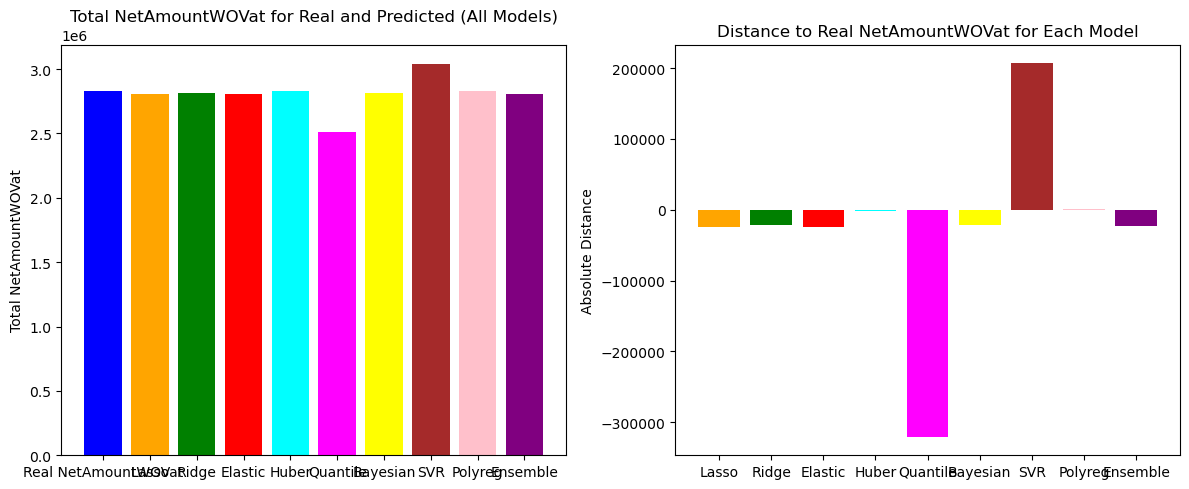

In [158]:
# Calculate the distance to real sales for each model
distance_lasso = lasso_sales - real_sales
distance_ridge = ridge_sales - real_sales
distance_elastic = elastic_sales - real_sales
distance_huber = huber_sales - real_sales
distance_quantile = quantile_sales - real_sales
distance_bayesian = bayesian_sales - real_sales
distance_svr = svr_sales - real_sales
distance_poly = poly_sales - real_sales
distance_ensemble = ensemble_sales - real_sales

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot real and predicted sales for all models
axes[0].bar([f'Real {desired_column}', 'Lasso', 'Ridge', 'Elastic', 'Huber', 'Quantile', 'Bayesian', 'SVR', 'Polyreg', 'Ensemble'],
            [real_sales, lasso_sales, ridge_sales, elastic_sales, huber_sales, quantile_sales, bayesian_sales, svr_sales, poly_sales, ensemble_sales],
            color=['blue', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'purple'])
axes[0].set_title(f'Total {desired_column} for Real and Predicted (All Models)')
axes[0].set_ylabel(f'Total {desired_column}')

# Plot distance to real sales for each model
axes[1].bar(['Lasso', 'Ridge', 'Elastic', 'Huber', 'Quantile', 'Bayesian', 'SVR', 'Polyreg', 'Ensemble'],
            [distance_lasso, distance_ridge, distance_elastic, distance_huber, distance_quantile, distance_bayesian, distance_svr, distance_poly, distance_ensemble],
            color=['orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'purple'])
axes[1].set_title(f'Distance to Real {desired_column} for Each Model')
axes[1].set_ylabel('Absolute Distance')

# Display the plots
plt.tight_layout()
plt.show()

# PHASE 5: Forecasting

## Prepare the emtpy set

In [159]:
start_timestamp = '2024-02-08 20:00:00'
end_timestamp = '2024-02-18 23:00:00'

forecast_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

forecast_df = pd.DataFrame(index=forecast_timestamps)

forecast_df[f'Forecasted {desired_column}'] = np.nan
forecast_df[f'{desired_column} Before'] = np.nan
forecast_df['RollingMean'] = np.nan
forecast_df['RollingStd'] = np.nan

forecast_df["HourInterval"] = forecast_df.index.hour
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek + 1

forecast_df = forecast_df[[f'Forecasted {desired_column}', 'HourInterval', 'DayOfWeek', f'{desired_column} Before', 'RollingMean', 'RollingStd']]

forecast_df.head(4)

,Forecasted NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
2024-02-08 20:00:00,NaN,20,4,NaN,NaN,NaN
2024-02-08 21:00:00,NaN,21,4,NaN,NaN,NaN
2024-02-08 22:00:00,NaN,22,4,NaN,NaN,NaN
2024-02-08 23:00:00,NaN,23,4,NaN,NaN,NaN


In [160]:
forecast_df.iloc[:3] = valid_df.iloc[-3:]

In [161]:
print(forecast_df.shape)
forecast_df.head(4)

(244, 6)


,Forecasted NetAmountWOVat,HourInterval,DayOfWeek,NetAmountWOVat Before,RollingMean,RollingStd
2024-02-08 20:00:00,1.039398,20,4,0.752435,1.172417,-0.341248
2024-02-08 21:00:00,0.554137,21,4,1.038309,0.898699,-0.370030
2024-02-08 22:00:00,-0.287751,22,4,0.552351,0.498322,0.588084
2024-02-08 23:00:00,NaN,23,4,NaN,NaN,NaN


## Forecasts

In [162]:
lasso_forecast_df = forecast_df.copy()
ridge_forecast_df = forecast_df.copy()
elastic_forecast_df = forecast_df.copy()
huber_forecast_df = forecast_df.copy()
quantile_forecast_df = forecast_df.copy()
bayesian_forecast_df = forecast_df.copy()
svr_forecast_df = forecast_df.copy()
poly_forecast_df = forecast_df.copy()

In [166]:
features = ['HourInterval', 'DayOfWeek', f'{desired_column} Before', 'RollingMean', 'RollingStd']

############################## Lasso ###########################################

for i in range(2, len(lasso_forecast_df) + 100):
    input_array = lasso_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = lasso_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    lasso_forecast_df.iloc[i + 1, lasso_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    lasso_forecast_df.iloc[i + 1, lasso_forecast_df.columns.get_loc(f'{desired_column} Before')] = lasso_forecast_df.iloc[i, lasso_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    lasso_forecast_df.iloc[i + 1, lasso_forecast_df.columns.get_loc('RollingMean')] = lasso_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    lasso_forecast_df.iloc[i + 1, lasso_forecast_df.columns.get_loc('RollingStd')] = lasso_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if lasso_forecast_df.isnull().sum()[0] == 0:
        break

############################## Ridge ################################

for i in range(2, len(ridge_forecast_df) + 100):
    input_array = ridge_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = ridge_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    ridge_forecast_df.iloc[i + 1, ridge_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    ridge_forecast_df.iloc[i + 1, ridge_forecast_df.columns.get_loc(f'{desired_column} Before')] = ridge_forecast_df.iloc[i, ridge_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    ridge_forecast_df.iloc[i + 1, ridge_forecast_df.columns.get_loc('RollingMean')] = ridge_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    ridge_forecast_df.iloc[i + 1, ridge_forecast_df.columns.get_loc('RollingStd')] = ridge_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if ridge_forecast_df.isnull().sum()[0] == 0:
        break

############################## Elastic ##########################################

for i in range(2, len(elastic_forecast_df) + 100):
    input_array = elastic_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = elastic_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    elastic_forecast_df.iloc[i + 1, elastic_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    elastic_forecast_df.iloc[i + 1, elastic_forecast_df.columns.get_loc(f'{desired_column} Before')] = elastic_forecast_df.iloc[i, elastic_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    elastic_forecast_df.iloc[i + 1, elastic_forecast_df.columns.get_loc('RollingMean')] = elastic_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    elastic_forecast_df.iloc[i + 1, elastic_forecast_df.columns.get_loc('RollingStd')] = elastic_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if elastic_forecast_df.isnull().sum()[0] == 0:
        break

############################## Huber ##########################################
for i in range(2, len(huber_forecast_df) + 100):
    input_array = huber_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = huber_best_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    huber_forecast_df.iloc[i + 1, huber_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    huber_forecast_df.iloc[i + 1, huber_forecast_df.columns.get_loc(f'{desired_column} Before')] = huber_forecast_df.iloc[i, huber_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    huber_forecast_df.iloc[i + 1, huber_forecast_df.columns.get_loc('RollingMean')] = huber_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    huber_forecast_df.iloc[i + 1, huber_forecast_df.columns.get_loc('RollingStd')] = huber_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if huber_forecast_df.isnull().sum()[0] == 0:
        break
        
############################## Quantile ##########################################

for i in range(2, len(quantile_forecast_df) + 100):
    input_array = quantile_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = quantile_best_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    quantile_forecast_df.iloc[i + 1, quantile_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    quantile_forecast_df.iloc[i + 1, quantile_forecast_df.columns.get_loc(f'{desired_column} Before')] = quantile_forecast_df.iloc[i, quantile_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    quantile_forecast_df.iloc[i + 1, quantile_forecast_df.columns.get_loc('RollingMean')] = quantile_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    quantile_forecast_df.iloc[i + 1, quantile_forecast_df.columns.get_loc('RollingStd')] = quantile_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if quantile_forecast_df.isnull().sum()[0] == 0:
        break

############################## Bayesian ##########################################

for i in range(2, len(bayesian_forecast_df) + 100):
    input_array = bayesian_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = bayesian_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    bayesian_forecast_df.iloc[i + 1, bayesian_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    bayesian_forecast_df.iloc[i + 1, bayesian_forecast_df.columns.get_loc(f'{desired_column} Before')] = bayesian_forecast_df.iloc[i, bayesian_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    bayesian_forecast_df.iloc[i + 1, bayesian_forecast_df.columns.get_loc('RollingMean')] = bayesian_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    bayesian_forecast_df.iloc[i + 1, bayesian_forecast_df.columns.get_loc('RollingStd')] = bayesian_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if bayesian_forecast_df.isnull().sum()[0] == 0:
        break

############################## SVR ##########################################

for i in range(2, len(svr_forecast_df) + 100):
    input_array = svr_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = svr_best_model.predict(input_df)
    
    # Update the "Predicted Sales" column
    svr_forecast_df.iloc[i + 1, svr_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    svr_forecast_df.iloc[i + 1, svr_forecast_df.columns.get_loc(f'{desired_column} Before')] = svr_forecast_df.iloc[i, svr_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    svr_forecast_df.iloc[i + 1, svr_forecast_df.columns.get_loc('RollingMean')] = svr_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    svr_forecast_df.iloc[i + 1, svr_forecast_df.columns.get_loc('RollingStd')] = svr_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if svr_forecast_df.isnull().sum()[0] == 0:
        break

############################## Poly ##########################################

for i in range(2, len(poly_forecast_df) + 100):
    input_array = poly_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    # Predict
    predicted_value = best_polyreg.predict(input_df)
    
    # Update the "Predicted Sales" column
    poly_forecast_df.iloc[i + 1, poly_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    # Update the "Sales Before" column with the predicted value
    poly_forecast_df.iloc[i + 1, poly_forecast_df.columns.get_loc(f'{desired_column} Before')] = poly_forecast_df.iloc[i, poly_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

    # Update the rolling stats
    window_size = 3
    poly_forecast_df.iloc[i + 1, poly_forecast_df.columns.get_loc('RollingMean')] = poly_forecast_df[f'Forecasted {desired_column}'][:i+1].mean()
    poly_forecast_df.iloc[i + 1, poly_forecast_df.columns.get_loc('RollingStd')] = poly_forecast_df[f'Forecasted {desired_column}'][:i+1].std()

    if poly_forecast_df.isnull().sum()[0] == 0:
        break

In [167]:
lasso_forecast_df_denorm = lasso_forecast_df.copy()
ridge_forecast_df_denorm = ridge_forecast_df.copy()
elastic_forecast_df_denorm = elastic_forecast_df.copy()
huber_forecast_df_denorm = huber_forecast_df.copy()
quantile_forecast_df_denorm = quantile_forecast_df.copy()
bayesian_forecast_df_denorm = bayesian_forecast_df.copy()
svr_forecast_df_denorm = svr_forecast_df.copy()
poly_forecast_df_denorm = poly_forecast_df.copy()

lasso_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (lasso_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
ridge_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (ridge_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
elastic_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (elastic_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
huber_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (huber_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
quantile_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (quantile_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
bayesian_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (bayesian_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
svr_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (svr_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean
poly_forecast_df_denorm[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] = (poly_forecast_df[[f'Forecasted {desired_column}', f'{desired_column} Before', 'RollingMean', 'RollingStd']] * std) + mean

## Plot Inference

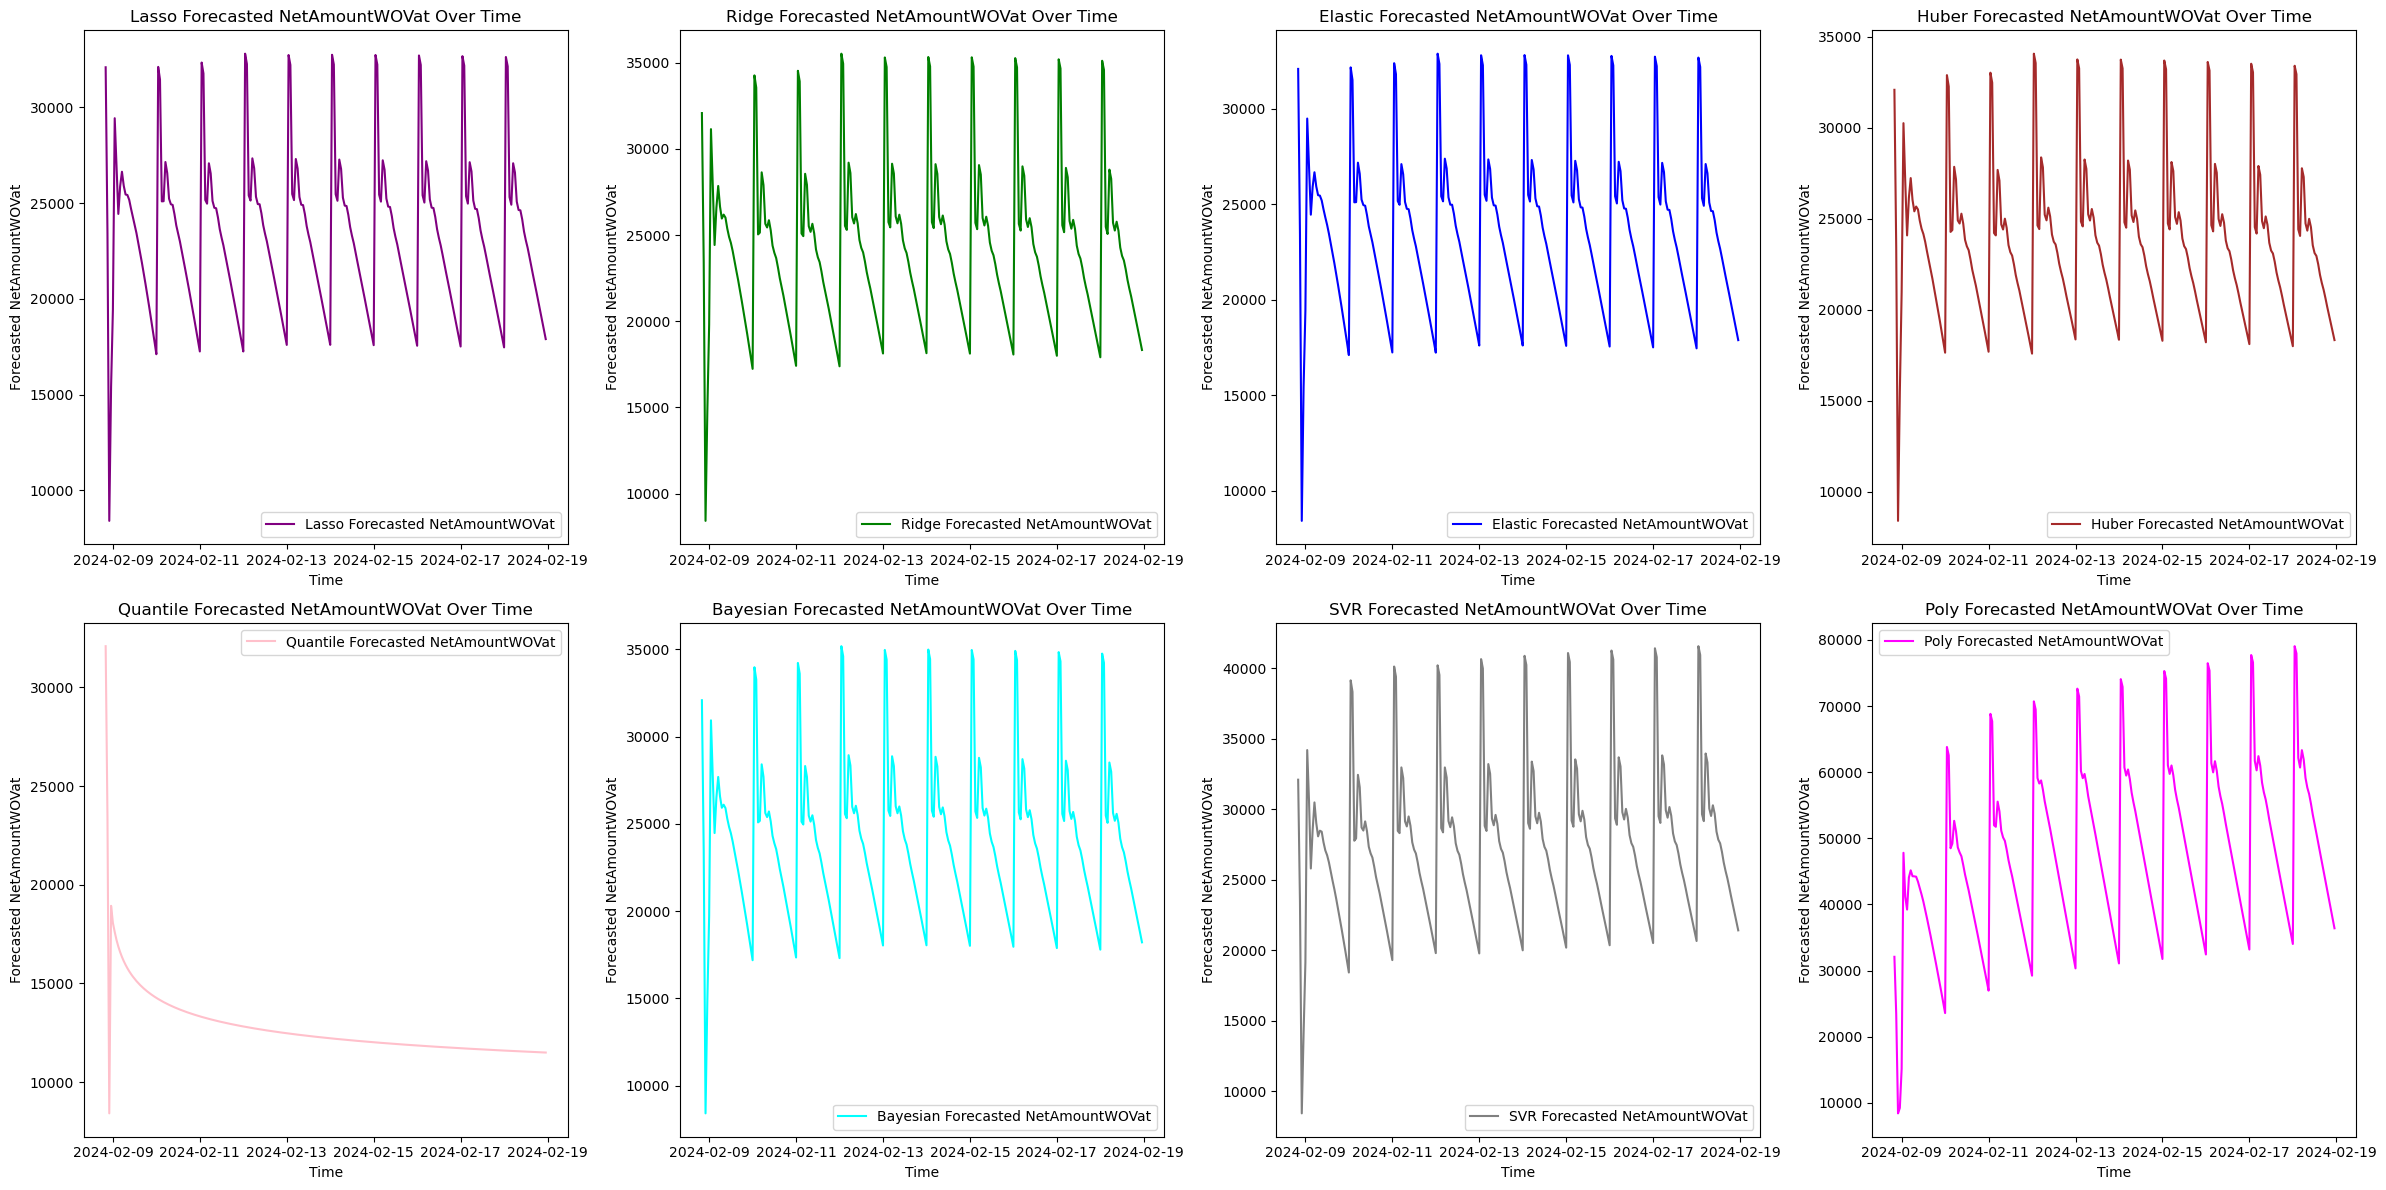

In [168]:
plt.figure(figsize=(24, 12))

# Plotting Lasso forecast
plt.subplot(2, 4, 1)
plt.plot(lasso_forecast_df_denorm.index, lasso_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Lasso Forecasted {desired_column}', c='purple')
plt.title(f'Lasso Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Ridge forecast
plt.subplot(2, 4, 2)
plt.plot(ridge_forecast_df_denorm.index, ridge_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Ridge Forecasted {desired_column}', c='green')
plt.title(f'Ridge Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Elastic forecast
plt.subplot(2, 4, 3)
plt.plot(elastic_forecast_df_denorm.index, elastic_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Elastic Forecasted {desired_column}', c='blue')
plt.title(f'Elastic Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Huber forecast
plt.subplot(2, 4, 4)
plt.plot(huber_forecast_df_denorm.index, huber_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Huber Forecasted {desired_column}', c='brown')
plt.title(f'Huber Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Quantile forecast
plt.subplot(2, 4, 5)
plt.plot(quantile_forecast_df_denorm.index, quantile_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Quantile Forecasted {desired_column}', c='pink')
plt.title(f'Quantile Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Bayesian forecast
plt.subplot(2, 4, 6)
plt.plot(bayesian_forecast_df_denorm.index, bayesian_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Bayesian Forecasted {desired_column}', c='cyan')
plt.title(f'Bayesian Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting SVR forecast
plt.subplot(2, 4, 7)
plt.plot(svr_forecast_df_denorm.index, svr_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'SVR Forecasted {desired_column}', c='gray')
plt.title(f'SVR Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

# Plotting Poly forecast
plt.subplot(2, 4, 8)
plt.plot(poly_forecast_df_denorm.index, poly_forecast_df_denorm[f'Forecasted {desired_column}'], label=f'Poly Forecasted {desired_column}', c='magenta')
plt.title(f'Poly Forecasted {desired_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'Forecasted {desired_column}')
plt.legend()

plt.tight_layout()
plt.show()

## Table Inference

In [169]:
predictions_by_day_lasso = lasso_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_lasso = predictions_by_day_lasso[[f"Forecasted {desired_column}"]].add_suffix('_Lasso')

predictions_by_day_ridge = ridge_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum() 
predictions_by_day_ridge = predictions_by_day_ridge[[f"Forecasted {desired_column}"]].add_suffix('_Ridge')

predictions_by_day_elastic = elastic_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_elastic = predictions_by_day_elastic[[f"Forecasted {desired_column}"]].add_suffix('_LGB')

predictions_by_day_ensemble = ensemble_forecast_df.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_ensemble = predictions_by_day_ensemble[[f"Forecasted {desired_column}"]].add_suffix('_Ensemble')

predictions_by_day_huber = huber_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_huber = predictions_by_day_huber[[f"Forecasted {desired_column}"]].add_suffix('_Huber')

predictions_by_day_quantile = quantile_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_quantile = predictions_by_day_quantile[[f"Forecasted {desired_column}"]].add_suffix('_Quantile')

predictions_by_day_bayesian = bayesian_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_bayesian = predictions_by_day_bayesian[[f"Forecasted {desired_column}"]].add_suffix('_Bayesian')

predictions_by_day_svr = svr_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_svr = predictions_by_day_svr[[f"Forecasted {desired_column}"]].add_suffix('_SVR')

predictions_by_day_poly = poly_forecast_df_denorm.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_poly = predictions_by_day_poly[[f"Forecasted {desired_column}"]].add_suffix('_Poly')

In [170]:
daily_predictions_df = pd.concat([predictions_by_day_lasso, predictions_by_day_ridge, predictions_by_day_elastic,
                                  predictions_by_day_huber, predictions_by_day_quantile, predictions_by_day_bayesian,
                                  predictions_by_day_svr, predictions_by_day_poly, predictions_by_day_ensemble], axis=1)

# Display the DataFrame
daily_predictions_df

,Forecasted NetAmountWOVat_Lasso,Forecasted NetAmountWOVat_Ridge,Forecasted NetAmountWOVat_LGB,Forecasted NetAmountWOVat_Huber,Forecasted NetAmountWOVat_Quantile,Forecasted NetAmountWOVat_Bayesian,Forecasted NetAmountWOVat_SVR,Forecasted NetAmountWOVat_Poly,Forecasted NetAmountWOVat_Ensemble
2024-02-08,79355.714837,78702.411085,79337.198822,79432.687751,82856.176274,78791.296989,78002.089373,7.316645e+04,79131.774915
2024-02-09,555288.958489,569530.111515,555688.354412,563805.918971,373706.713278,567629.217760,615221.324715,8.887106e+05,560169.141472
2024-02-10,556296.669001,572074.541565,556507.580305,562015.392810,330191.003645,569545.715579,640819.100236,1.017599e+06,561626.263624
2024-02-11,554322.748242,569520.666505,554330.058450,557607.507818,313530.119591,566723.176779,651905.054768,1.080323e+06,559391.157732
2024-02-12,560273.869462,583871.764987,560895.401891,572636.362514,303409.095503,580646.993466,651754.432141,1.148446e+06,568347.012114
2024-02-13,559940.368620,584208.074441,560543.184348,572211.661984,296269.673331,580821.153609,656258.029418,1.168968e+06,568230.542470
2024-02-14,559144.489091,583384.963255,559680.953225,570670.430110,290819.997245,579877.749309,660323.248283,1.184451e+06,567403.468524
2024-02-15,558131.697825,581947.331205,558578.484567,568553.079681,286449.636775,578350.971575,664035.756458,1.198868e+06,566219.171199
2024-02-16,556965.955634,580071.700763,557306.403502,566026.254812,282823.820535,576408.728127,667498.720977,1.214313e+06,564781.353300
2024-02-17,555686.350055,577867.804711,555907.965600,563193.341980,279740.101325,574155.302173,670775.555541,1.231990e+06,563154.040122


# PHASE 6: Explainable AI

## Classic

In [181]:
# Lasso Regression
lasso_coeffs = lasso_model.coef_
lasso_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_coeffs})
lasso_feature_importance['Absolute Coefficient'] = np.abs(lasso_feature_importance['Coefficient'])
lasso_feature_importance = lasso_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Lasso Regression:")
print(lasso_feature_importance)
print("")

# Ridge Regression
ridge_coeffs = ridge_model.coef_
ridge_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge_coeffs})
ridge_feature_importance['Absolute Coefficient'] = np.abs(ridge_feature_importance['Coefficient'])
ridge_feature_importance = ridge_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Ridge Regression:")
print(ridge_feature_importance)
print("")

# Elastic Net Regression
elasticnet_coeffs = elastic_model.coef_
elasticnet_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': elasticnet_coeffs})
elasticnet_feature_importance['Absolute Coefficient'] = np.abs(elasticnet_feature_importance['Coefficient'])
elasticnet_feature_importance = elasticnet_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Elastic Net Regression:")
print(elasticnet_feature_importance)
print("")

# Huber Regression
huber_coeffs = huber_best_model.coef_
huber_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': huber_coeffs})
huber_feature_importance['Absolute Coefficient'] = np.abs(huber_feature_importance['Coefficient'])
huber_feature_importance = huber_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Huber Regression:")
print(huber_feature_importance)
print("")

# Quantile Regression
quantile_coeffs = quantile_best_model.coef_
quantile_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': quantile_coeffs})
quantile_feature_importance['Absolute Coefficient'] = np.abs(quantile_feature_importance['Coefficient'])
quantile_feature_importance = quantile_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Quantile Regression:")
print(quantile_feature_importance)
print("")

# Bayesian Regression
bayesian_coeffs = bayesian_model.coef_
bayesian_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': bayesian_coeffs})
bayesian_feature_importance['Absolute Coefficient'] = np.abs(bayesian_feature_importance['Coefficient'])
bayesian_feature_importance = bayesian_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Bayesian Regression:")
print(bayesian_feature_importance)
print("")

# SVR Regression
""" there is no classic way for this """

# Poly Regression
poly_model = best_polyreg.named_steps['linearregression']

poly_coeffs = poly_model.coef_[:len(X_train.columns)]

poly_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': poly_coeffs})
poly_feature_importance['Absolute Coefficient'] = np.abs(poly_feature_importance['Coefficient'])
poly_feature_importance = poly_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Poly Regression:")
print(poly_feature_importance)
print("")

Lasso Regression:
                 Feature  Coefficient  Absolute Coefficient
3            RollingMean     1.387250              1.387250
2  NetAmountWOVat Before    -0.411022              0.411022
4             RollingStd     0.040497              0.040497
0           HourInterval    -0.036684              0.036684
1              DayOfWeek    -0.003459              0.003459

Ridge Regression:
                 Feature  Coefficient  Absolute Coefficient
3            RollingMean     1.481347              1.481347
2  NetAmountWOVat Before    -0.490692              0.490692
4             RollingStd     0.062889              0.062889
0           HourInterval    -0.041755              0.041755
1              DayOfWeek    -0.007908              0.007908

Elastic Net Regression:
                 Feature  Coefficient  Absolute Coefficient
3            RollingMean     1.387452              1.387452
2  NetAmountWOVat Before    -0.412061              0.412061
4             RollingStd     0.042914 

## SHAP

In [106]:
import shap

In [187]:
# Lasso
explainer_lasso = shap.LinearExplainer(lasso_model, X_train)
shap_values_lasso_valid = explainer_lasso.shap_values(X_valid)
shap_values_lasso_train = explainer_lasso.shap_values(X_train)

df_shap_lasso_valid = pd.DataFrame(shap_values_lasso_valid, columns=X_valid.columns.values)
df_shap_lasso_train = pd.DataFrame(shap_values_lasso_train, columns=X_train.columns.values)

# Ridge
explainer_ridge = shap.LinearExplainer(ridge_model, X_train)
shap_values_ridge_valid = explainer_ridge.shap_values(X_valid)
shap_values_ridge_train = explainer_ridge.shap_values(X_train)

df_shap_ridge_valid = pd.DataFrame(shap_values_ridge_valid, columns=X_valid.columns.values)
df_shap_ridge_train = pd.DataFrame(shap_values_ridge_train, columns=X_train.columns.values)

# Elastic
explainer_elastic = shap.LinearExplainer(elastic_model, X_train)
shap_values_elastic_valid = explainer_elastic.shap_values(X_valid)
shap_values_elastic_train = explainer_elastic.shap_values(X_train)

df_shap_elastic_valid = pd.DataFrame(shap_values_elastic_valid, columns=X_valid.columns.values)
df_shap_elastic_train = pd.DataFrame(shap_values_elastic_train, columns=X_train.columns.values)

# Huber
explainer_huber = shap.LinearExplainer(huber_best_model, X_train)
shap_values_huber_valid = explainer_huber.shap_values(X_valid)
shap_values_huber_train = explainer_huber.shap_values(X_train)

df_shap_huber_valid = pd.DataFrame(shap_values_huber_valid, columns=X_valid.columns.values)
df_shap_huber_train = pd.DataFrame(shap_values_huber_train, columns=X_train.columns.values)

# Quantile 
explainer_quantile = shap.LinearExplainer(quantile_best_model, X_train)
shap_values_quantile_valid = explainer_quantile.shap_values(X_valid)
shap_values_quantile_train = explainer_quantile.shap_values(X_train)

df_shap_quantile_valid = pd.DataFrame(shap_values_quantile_valid, columns=X_valid.columns.values)
df_shap_quantile_train = pd.DataFrame(shap_values_quantile_train, columns=X_train.columns.values)

# Bayesian Ridge 
explainer_bayesian = shap.LinearExplainer(bayesian_model, X_train)
shap_values_bayesian_valid = explainer_bayesian.shap_values(X_valid)
shap_values_bayesian_train = explainer_bayesian.shap_values(X_train)

df_shap_bayesian_valid = pd.DataFrame(shap_values_bayesian_valid, columns=X_valid.columns.values)
df_shap_bayesian_train = pd.DataFrame(shap_values_bayesian_train, columns=X_train.columns.values)

# SVR 
explainer_svr = shap.LinearExplainer(svr_best_model, X_train)
shap_values_svr_valid = explainer_svr.shap_values(X_valid)
shap_values_svr_train = explainer_svr.shap_values(X_train)

df_shap_svr_valid = pd.DataFrame(shap_values_svr_valid, columns=X_valid.columns.values)
df_shap_svr_train = pd.DataFrame(shap_values_svr_train, columns=X_train.columns.values)

# Poly Regression 
def poly_predict(data):
    return best_polyreg.predict(data)

explainer_poly = shap.KernelExplainer(poly_predict, X_train)
shap_values_poly_valid = explainer_poly.shap_values(X_valid)
shap_values_poly_train = explainer_poly.shap_values(X_train)

df_shap_poly_valid = pd.DataFrame(shap_values_poly_valid, columns=X_valid.columns.values)
df_shap_poly_train = pd.DataFrame(shap_values_poly_train, columns=X_train.columns.values)

Using 162 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:09<00:00, 16.44it/s]


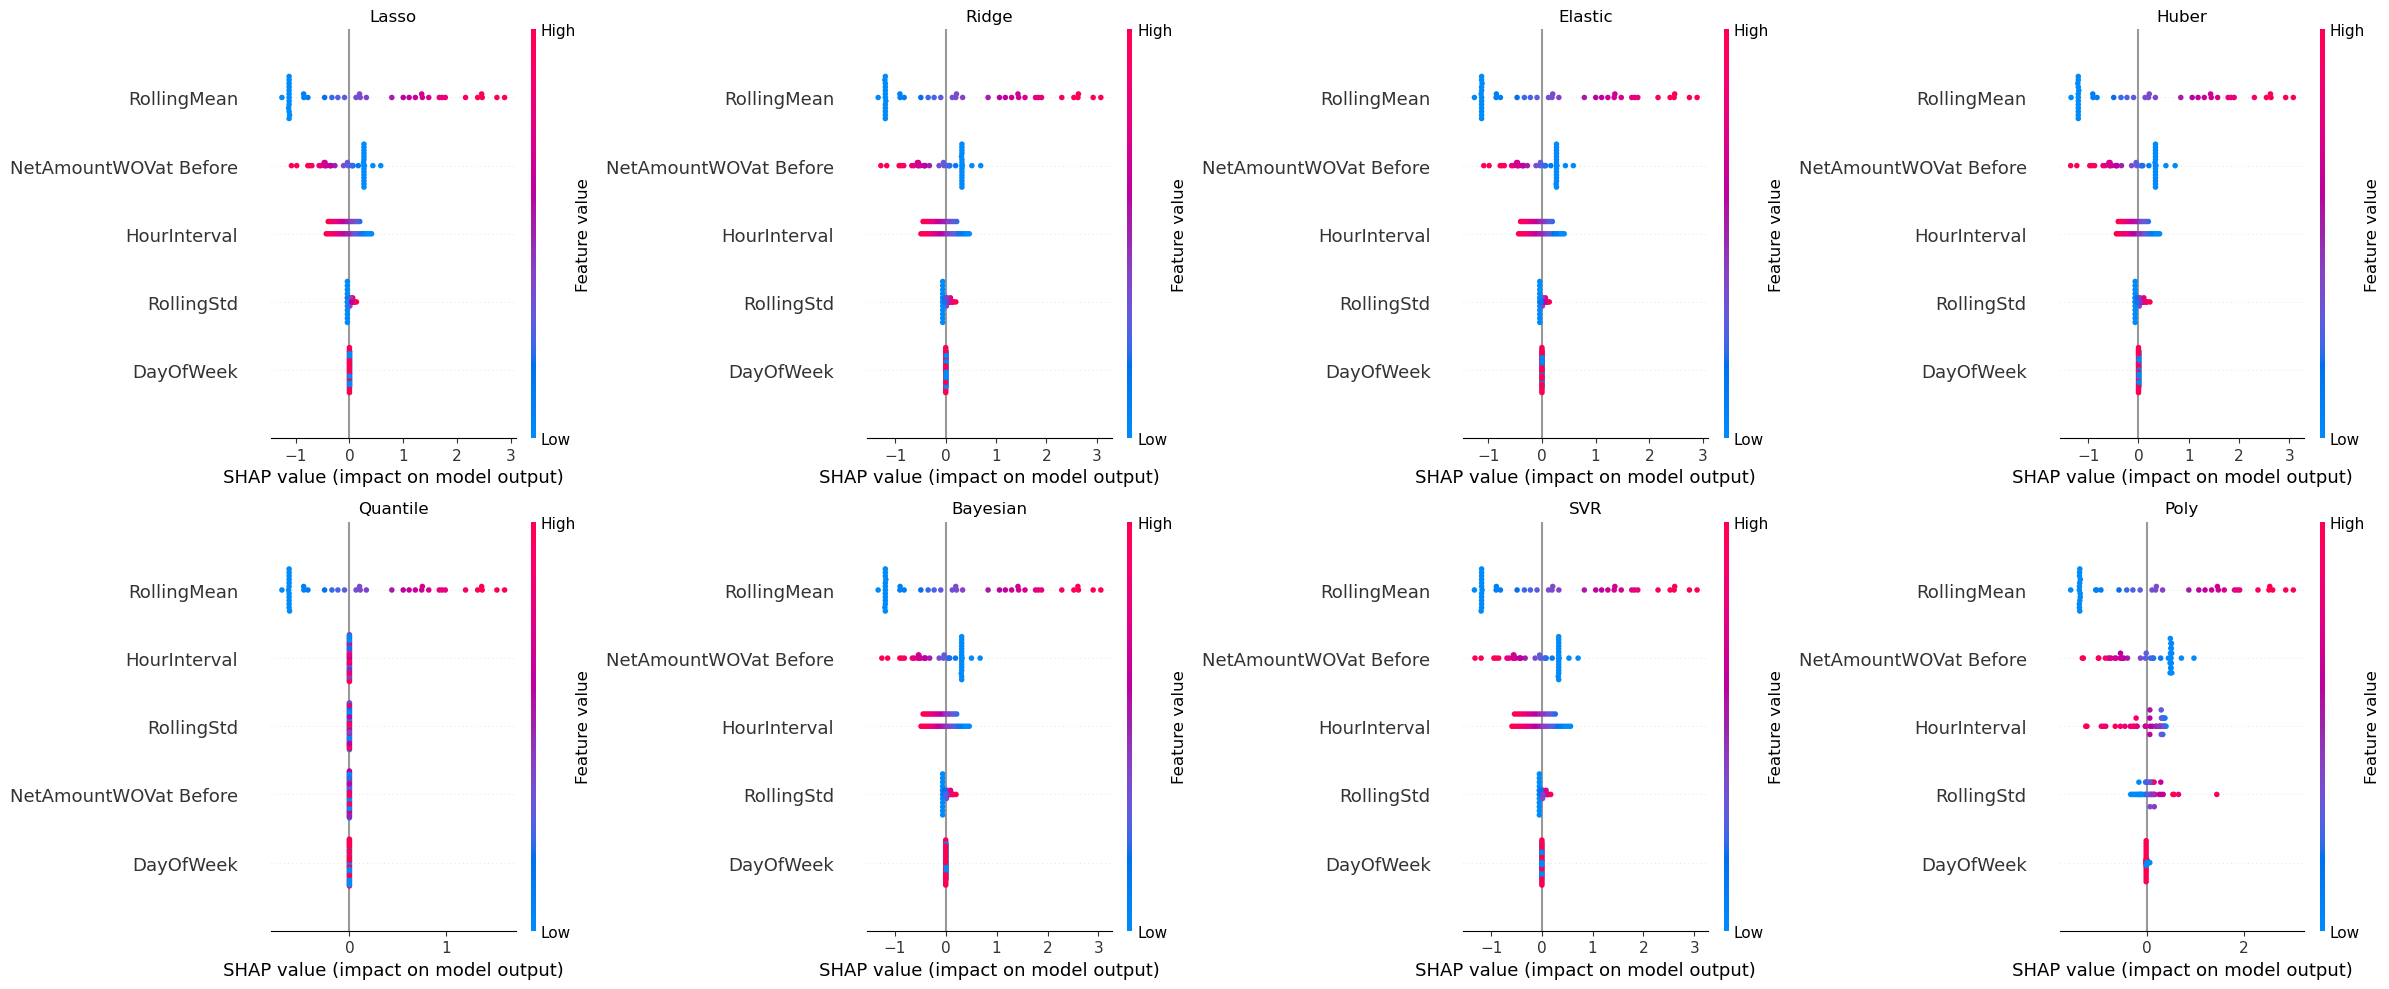

In [191]:
# Plotting for SVR
plt.figure(figsize=(24, 10))

# Plotting for Lasso
plt.subplot(2, 4, 1)
shap.summary_plot(shap_values_lasso_valid, X_valid, plot_size=None, show=False)
plt.title('Lasso')

# Plotting for Ridge
plt.subplot(2, 4, 2)
shap.summary_plot(shap_values_ridge_valid, X_valid, plot_size=None, show=False)
plt.title('Ridge')

# Plotting for Elastic
plt.subplot(2, 4, 3)
shap.summary_plot(shap_values_elastic_valid, X_valid, plot_size=None, show=False)
plt.title('Elastic')

# Plotting for Huber
plt.subplot(2, 4, 4)
shap.summary_plot(shap_values_huber_valid, X_valid, plot_size=None, show=False)
plt.title('Huber')

# Plotting for Quantile
plt.subplot(2, 4, 5)
shap.summary_plot(shap_values_quantile_valid, X_valid, plot_size=None, show=False)
plt.title('Quantile')

# Plotting for Bayesian
plt.subplot(2, 4, 6)
shap.summary_plot(shap_values_bayesian_valid, X_valid, plot_size=None, show=False)
plt.title('Bayesian')

# Plotting for SVR
plt.subplot(2, 4, 7)
shap.summary_plot(shap_values_svr_valid, X_valid, plot_size=None, show=False)
plt.title('SVR')

# Plotting for Poly
plt.subplot(2, 4, 8)
shap.summary_plot(shap_values_poly_valid, X_valid, plot_size=None, show=False)
plt.title('Poly')

plt.tight_layout()
plt.show()

In [194]:
# j will be the record we explain
j = 40
sample = X_valid.iloc[[j]]
print(sample)
print("")

# init js
shap.initjs()

# Lasso
lasso_out = int(lasso_model.predict(sample) * std + mean)
print("Lasso prediction")
print("Denorm amount:", lasso_out)
display(shap.force_plot(explainer_lasso.expected_value, shap_values_lasso_valid[j], sample))

# Ridge
ridge_out = int(ridge_model.predict(sample) * std + mean)
print("Ridge prediction")
print("Denorm amount:", ridge_out)
display(shap.force_plot(explainer_ridge.expected_value, shap_values_ridge_valid[j], sample))

# Elastic
elastic_out = int(elastic_model.predict(sample) * std + mean)
print("Elastic prediction")
print("Denorm amount:", elastic_out)
display(shap.force_plot(explainer_elastic.expected_value, shap_values_elastic_valid[j], sample))

# Huber
huber_out = int(huber_best_model.predict(sample) * std + mean)
print("Huber prediction")
print("Denorm amount:", huber_out)
display(shap.force_plot(explainer_huber.expected_value, shap_values_huber_valid[j], sample))

# Quantile
quantile_out = int(quantile_best_model.predict(sample) * std + mean)
print("Quantile prediction")
print("Denorm amount:", quantile_out)
display(shap.force_plot(explainer_quantile.expected_value, shap_values_quantile_valid[j], sample))

# Bayesian
bayesian_out = int(bayesian_model.predict(sample) * std + mean)
print("Bayesian prediction")
print("Denorm Amount:", bayesian_out)
display(shap.force_plot(explainer_bayesian.expected_value, shap_values_bayesian_valid[j], sample))

# SVR
svr_out = int(svr_best_model.predict(sample) * std + mean)
print("SVR prediction")
print("Denorm Amount:", svr_out)
display(shap.force_plot(explainer_svr.expected_value, shap_values_svr_valid[j], sample))

# Poly
poly_out = int(best_polyreg.predict(sample) * std + mean)
print("Poly prediction")
print("Denorm Amount:", poly_out)
display(shap.force_plot(explainer_poly.expected_value, shap_values_poly_valid[j], sample))

# Ensemble
ensemble_out = int((lasso_out + ridge_out + elastic_out + huber_out + quantile_out + bayesian_out + svr_out + poly_out) / 8)
print("Ensemble prediction")
print("Denorm Amount:", ensemble_out)

ensemble_expected = (explainer_lasso.expected_value + explainer_ridge.expected_value + explainer_elastic.expected_value +
                     explainer_huber.expected_value + explainer_quantile.expected_value + explainer_bayesian.expected_value +
                     explainer_svr.expected_value + explainer_poly.expected_value) / 8

ensemble_values = (shap_values_lasso_valid[j] + shap_values_ridge_valid[j] + shap_values_elastic_valid[j] +
                   shap_values_huber_valid[j] + shap_values_quantile_valid[j] + shap_values_bayesian_valid[j] +
                   shap_values_svr_valid[j] + shap_values_poly_valid[j]) / 8

display(shap.force_plot(ensemble_expected, ensemble_values, sample))


                     HourInterval  DayOfWeek  NetAmountWOVat Before  \
TransactionDateTime                                                   
2024-02-08 22:00:00            22          4               0.552351   

                     RollingMean  RollingStd  
TransactionDateTime                           
2024-02-08 22:00:00     0.498322    0.588084  



Lasso prediction
Denorm amount: 15428


Ridge prediction
Denorm amount: 14775


Elastic prediction
Denorm amount: 15410


Huber prediction
Denorm amount: 15505


Quantile prediction
Denorm amount: 18929


Bayesian prediction
Denorm Amount: 14864


SVR prediction
Denorm Amount: 14075


Poly prediction
Denorm Amount: 9239


Ensemble prediction
Denorm Amount: 14778
